# PulseTrackz
## Spin Class Playlist ML Model

![banner image](https://metpro.co/wp-content/uploads/2023/03/AdobeStock_406831633-scaled.jpeg)

## Scenario

Fitness instructors and enthusiasts alike face a recurring challenge: creating the perfect playlist for spin classes that aligns with workout phases like warm-up, sprint, climb, interval, and cool-down. Manually curating these playlists is time-consuming, subjective, and often lacks the precision to match the energy dynamics of a class. Platforms like Spotify offer massive music libraries, but not tools tailored for exercise-specific curation. Popular apps like Peloton offer energetic classes, but don’t give users the ability to customize their classes around their own unique music tastes. PulseTrackz addresses these gaps by automatically generating spin-class playlists that are optimized for workout flow using machine learning classification.

## Data Import

In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
from collections import Counter, defaultdict
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import label_binarize


In [2]:
# Load data
df = pd.read_csv('train.csv')

# Show basic info and summary
print("\nDataFrame Shape:")
print(df.shape)

print("\nDataFrame Info:")
print(df.info())

print("\nFirst few rows:")
print(df.head())

print("\nSummary stats:")
print(df.describe())



DataFrame Shape:
(114000, 21)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  11

## Data Exploration

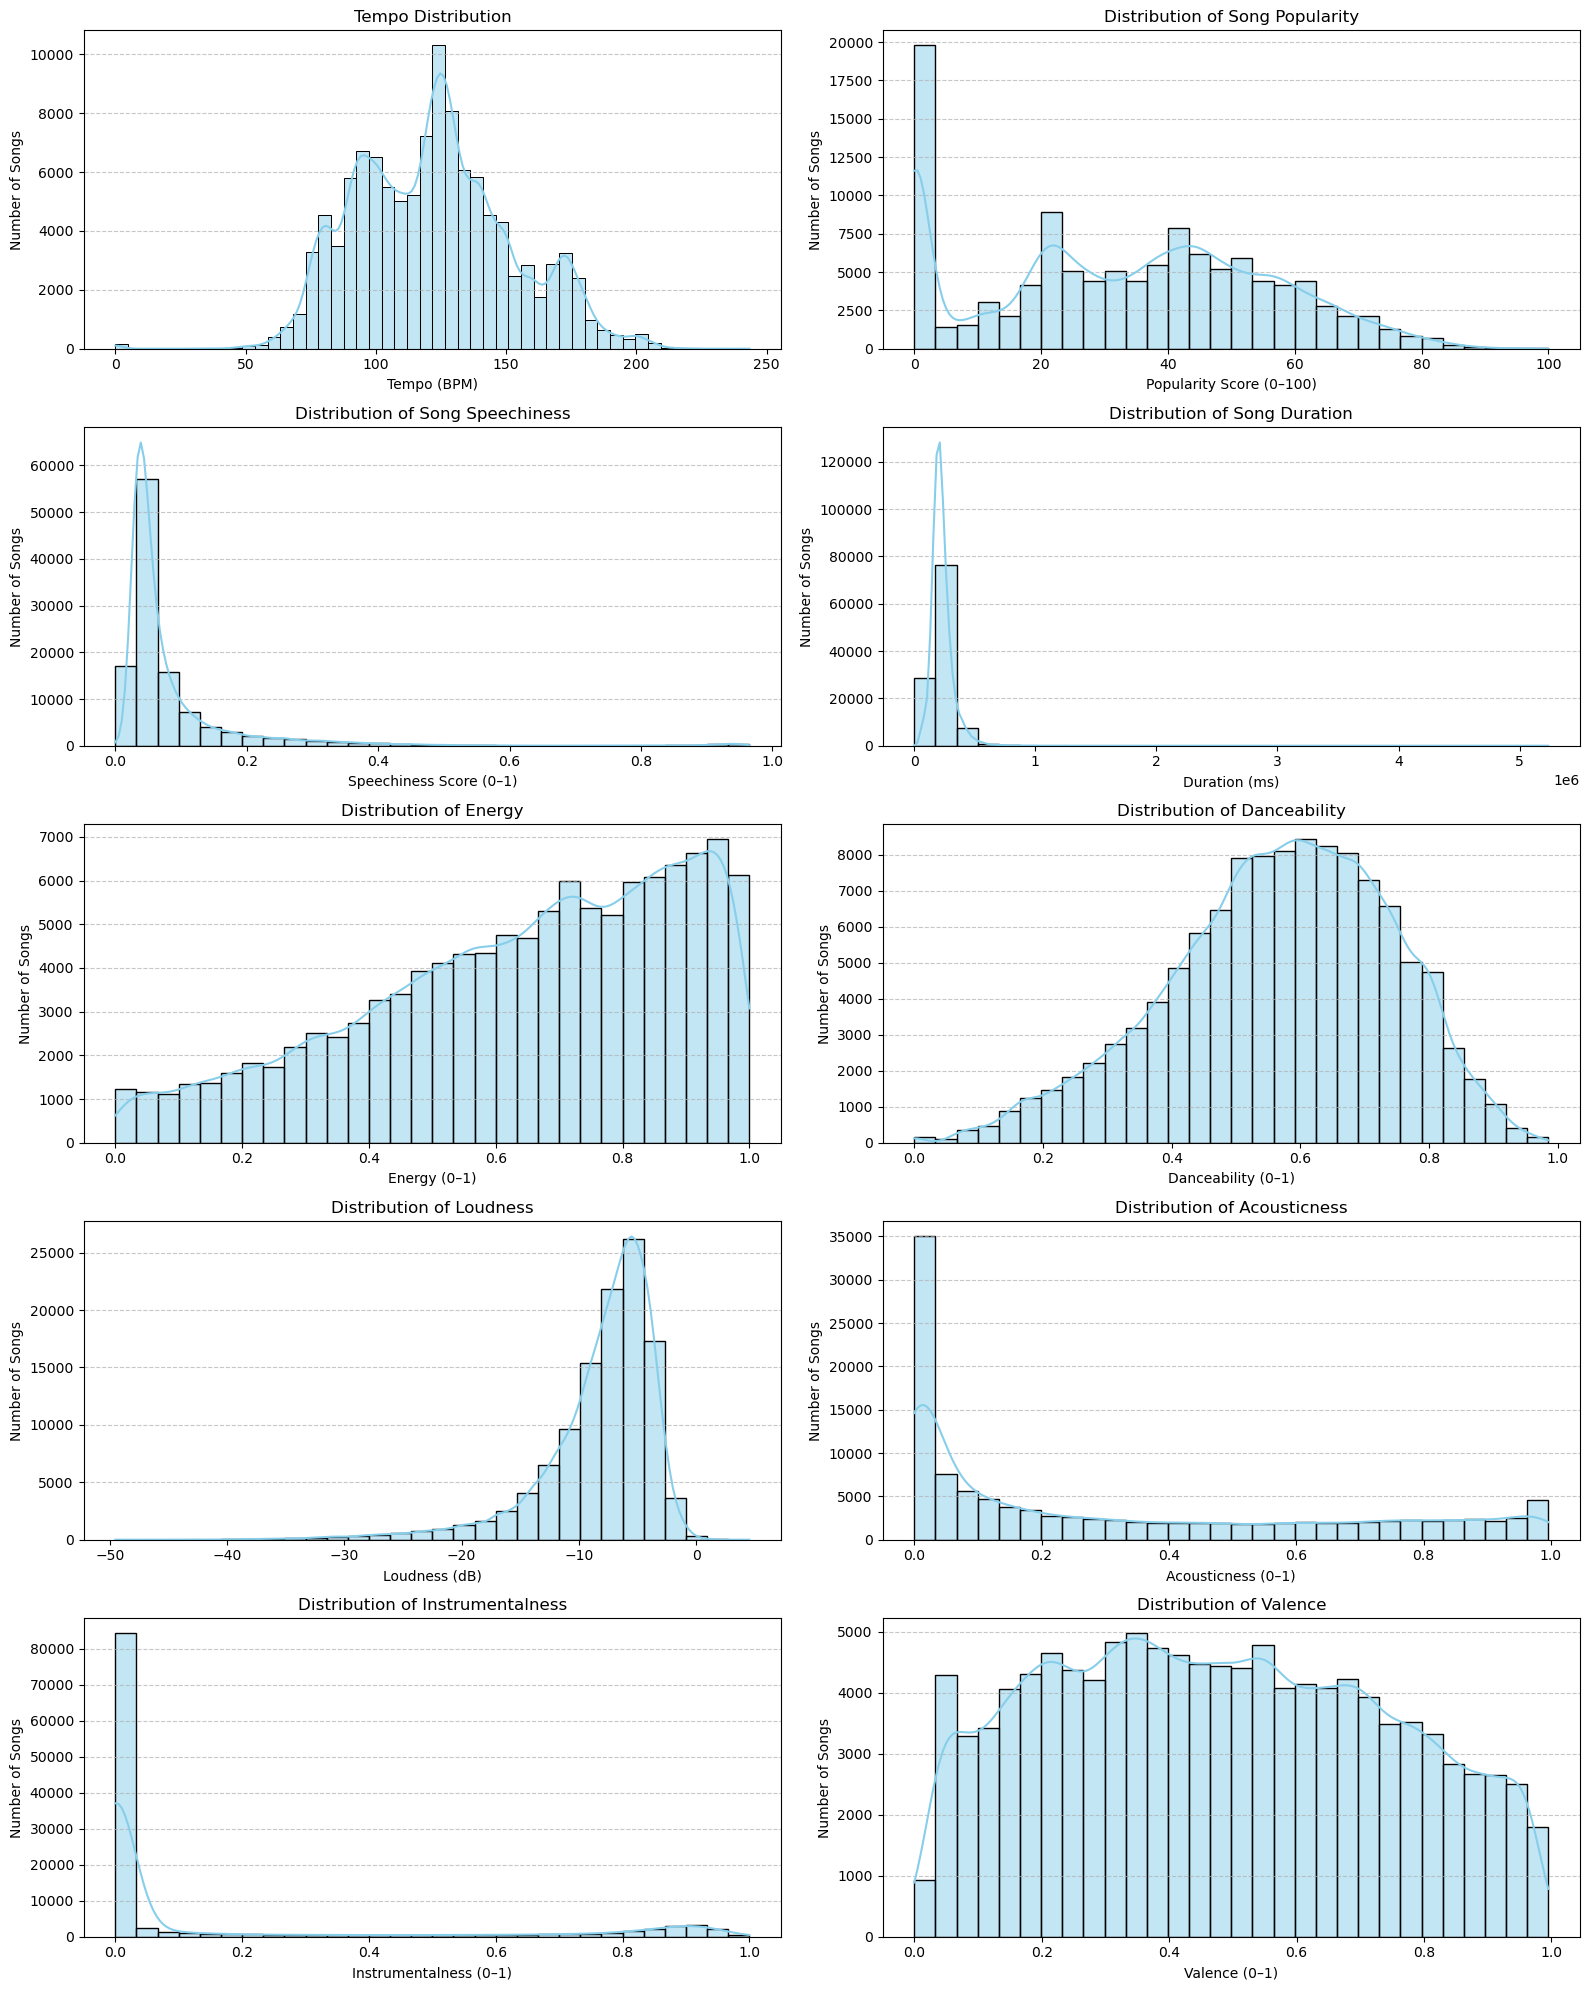

In [3]:
# Plot key quantitative features
def plot_hist(ax, data, column, title, xlabel, bins=30, color='skyblue'):
    sns.histplot(data[column], bins=bins, kde=True, color=color, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Number of Songs')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Create 5x2 grid
fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()

# Define plots
plot_configs = [
    ('tempo', 'Tempo Distribution', 'Tempo (BPM)', 50),
    ('popularity', 'Distribution of Song Popularity', 'Popularity Score (0–100)', 30),
    ('speechiness', 'Distribution of Song Speechiness', 'Speechiness Score (0–1)', 30),
    ('duration_ms', 'Distribution of Song Duration', 'Duration (ms)', 30),
    ('energy', 'Distribution of Energy', 'Energy (0–1)', 30),
    ('danceability', 'Distribution of Danceability', 'Danceability (0–1)', 30),
    ('loudness', 'Distribution of Loudness', 'Loudness (dB)', 30),
    ('acousticness', 'Distribution of Acousticness', 'Acousticness (0–1)', 30),
    ('instrumentalness', 'Distribution of Instrumentalness', 'Instrumentalness (0–1)', 30),
    ('valence', 'Distribution of Valence', 'Valence (0–1)', 30),
]

# Plot all charts
for ax, (col, title, xlabel, bins) in zip(axes, plot_configs):
    plot_hist(ax, df, col, title, xlabel, bins=bins)

# Layout
plt.tight_layout()
plt.show()


In [4]:
# Convert duration_ms to MM:SS format
df['duration_MM_SS'] = df['duration_ms'].apply(lambda x: f"{int(x // 60000):02}:{int((x % 60000) // 1000):02}")

df['duration_MM_SS'].head()

0    03:50
1    02:29
2    03:30
3    03:21
4    03:18
Name: duration_MM_SS, dtype: object

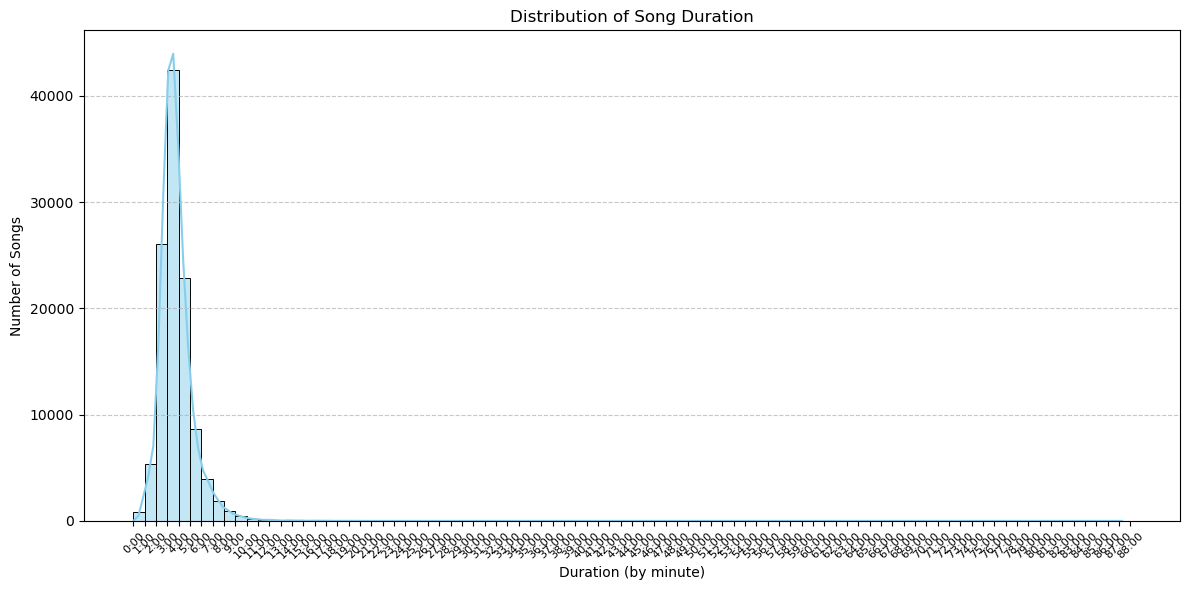

In [5]:
# Distribution of Duration
# Convert duration_ms to seconds
df['duration_sec'] = df['duration_ms'] // 1000

# Create bins of 30-second intervals
bin_width = 60
max_duration = df['duration_sec'].max()
bins = range(0, int(max_duration + bin_width), bin_width)

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(df['duration_sec'], bins=bins, kde=True, color='skyblue')

plt.title('Distribution of Song Duration')
plt.xlabel('Duration (by minute)')
plt.ylabel('Number of Songs')
plt.xticks(ticks=bins, labels=[f"{int(b//60)}:{int(b%60):02}" for b in bins], rotation=45, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

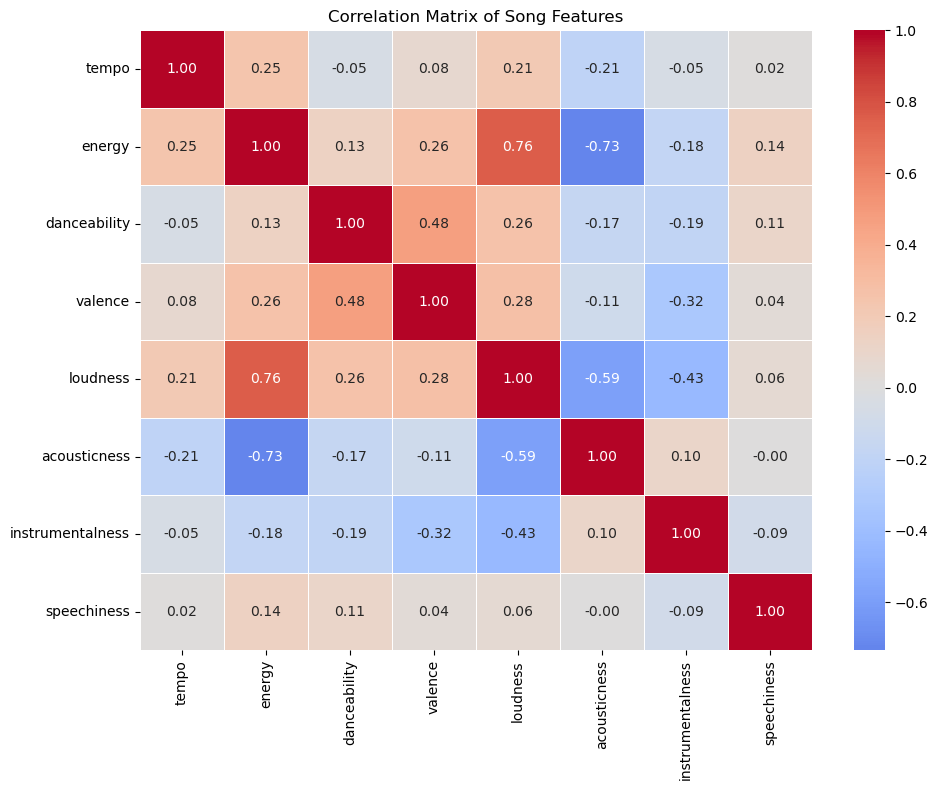

In [6]:
# Correlation Matrix
numeric_features = ['tempo', 'energy', 'danceability', 'valence', 'loudness',
                    'acousticness', 'instrumentalness', 'speechiness']

# Compute correlation matrix
corr_matrix = df[numeric_features].corr()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Song Features')
plt.tight_layout()
plt.show()


In [7]:
# Top Artists
def parse_artists(val):
    if isinstance(val, str):
        return [artist.strip() for artist in val.split(';')]
    return []

# Apply parser
artist_lists = df['artists'].dropna().apply(parse_artists)

# Flatten and count
flat_artists = [artist for sublist in artist_lists for artist in sublist]
artist_counts = Counter(flat_artists)
top_artists = artist_counts.most_common(10)

# Display results
print("Top 10 Most Common Artists:")
for i, (artist, count) in enumerate(top_artists, 1):
    print(f"{i}. {artist}: {count} songs")


Top 10 Most Common Artists:
1. J Balvin: 510 songs
2. Bad Bunny: 416 songs
3. Daddy Yankee: 375 songs
4. Wolfgang Amadeus Mozart: 354 songs
5. Feid: 348 songs
6. George Jones: 343 songs
7. Pritam: 333 songs
8. Arijit Singh: 305 songs
9. ILLENIUM: 298 songs
10. The Beatles: 280 songs


In [8]:
# Check numeric features by artists
# Parse artists using the current format
def parse_artists(val):
    if isinstance(val, str):
        return [artist.strip() for artist in val.split(';')]
    return []

# Apply 
df_copy = df.copy()
df_copy['artists_list'] = df_copy['artists'].apply(parse_artists)
df_exploded = df_copy.explode('artists_list')

# Filter to top 10 artists
top_10_names = [artist for artist, _ in top_artists]
filtered = df_exploded[df_exploded['artists_list'].isin(top_10_names)]

# Group and summarize by tempo, energy, and danceability
artist_stats = filtered.groupby('artists_list')[['tempo', 'energy', 'danceability']].mean().sort_values(by='tempo', ascending=False)

# Display
print("Average Tempo, Energy, and Danceability for Top 10 Artists:")
print(artist_stats)


Average Tempo, Energy, and Danceability for Top 10 Artists:
                              tempo    energy  danceability
artists_list                                               
Feid                     139.236848  0.637839      0.764468
ILLENIUM                 139.161634  0.720721      0.468138
The Beatles              122.552939  0.540763      0.519114
J Balvin                 122.339737  0.738053      0.767957
Arijit Singh             116.177407  0.592059      0.530426
Pritam                   114.321586  0.711018      0.593760
Daddy Yankee             112.968816  0.835701      0.754843
Wolfgang Amadeus Mozart  111.036588  0.121095      0.411643
Bad Bunny                110.918115  0.691075      0.760397
George Jones             109.318924  0.357306      0.538583


In [9]:
# Top Artist by Genre
# Parse artists into lists
df_copy = df.copy()
df_copy['artists_list'] = df_copy['artists'].apply(parse_artists)

# Explode artists to get one row per artist-track
df_exploded = df_copy.explode('artists_list')

# Group by genre and artist, then count
genre_artist_counts = df_exploded.groupby(['track_genre', 'artists_list']).size().reset_index(name='count')

# For each genre, get top artist(s)
top_artists_by_genre = (
    genre_artist_counts
    .sort_values(['track_genre', 'count'], ascending=[True, False])
    .groupby('track_genre')
    .head(1)
)

# Display
pd.set_option('display.max_rows', None) 
print("Top Artist by Genre:")
display(top_artists_by_genre)


Top Artist by Genre:


,track_genre,artists_list,count
52,acoustic,Boyce Avenue,45
409,afrobeat,Criolo,73
979,alt-rock,Red Hot Chili Peppers,38
1178,alternative,GAYLE,41
1651,ambient,Ludovico Einaudi,69
1950,anime,Kato,56
2280,black-metal,Hypocrisy,29
2525,bluegrass,Greensky Bluegrass,56
2799,blues,Ella Fitzgerald,131
3355,brazil,Maneva,31


## Feature Engineering

In [10]:
# Create new 'spin genre' feature
spin_genre_map = {
    # Pop/EDM/Electronic
    'pop': 'pop/edm',
    'dance': 'pop/edm',
    'edm': 'pop/edm',
    'club': 'pop/edm',
    'house': 'pop/edm',
    'deep-house': 'pop/edm',
    'electro': 'pop/edm',
    'electronic': 'pop/edm',
    'progressive-house': 'pop/edm',
    'synth-pop': 'pop/edm',
    'trance': 'pop/edm',
    'disco': 'pop/edm',
    'party': 'pop/edm',
    'techno': 'pop/edm',
    'garage': 'pop/edm',
    'detroit-techno': 'pop/edm',
    'minimal-techno': 'pop/edm',
    'breakbeat': 'pop/edm',
    'drum-and-bass': 'pop/edm',
    'dubstep': 'pop/edm',
    'trip-hop': 'pop/edm',
    'idm': 'pop/edm',
    'british': 'pop/edm',
    'chicago-house': 'pop/edm',
    'dub': 'pop/edm',
    'garage': 'pop/edm',

    # Rock/Alternative
    'rock': 'rock/alt',
    'alt-rock': 'rock/alt',
    'alternative': 'rock/alt',
    'indie': 'rock/alt',
    'indie-pop': 'rock/alt',
    'punk': 'rock/alt',
    'punk-rock': 'rock/alt',
    'psych-rock': 'rock/alt',
    'grunge': 'rock/alt',
    'goth': 'rock/alt',
    'emo': 'rock/alt',
    'hard-rock': 'rock/alt',
    'hardcore': 'rock/alt',
    'metal': 'rock/alt',
    'heavy-metal': 'rock/alt',
    'death-metal': 'rock/alt',
    'metalcore': 'rock/alt',
    'grindcore': 'rock/alt',
    'rock-n-roll': 'rock/alt',
    'rockabilly': 'rock/alt',

    # Hip-Hop/Rap
    'hip-hop': 'hip hop',
    'rap': 'hip hop',

    # R&B/Soul/Funk
    'r-n-b': 'r&b/soul',
    'soul': 'r&b/soul',
    'funk': 'r&b/soul',
    'gospel': 'r&b/soul',
    'groove': 'r&b/soul',

    # Singer-Songwriter/Folk/Acoustic
    'acoustic': 'acoustic/folk',
    'folk': 'acoustic/folk',
    'bluegrass': 'acoustic/folk',
    'singer-songwriter': 'acoustic/folk',
    'songwriter': 'acoustic/folk',
    'country': 'acoustic/folk',
    'americana': 'acoustic/folk',
    'honky-tonk': 'acoustic/folk',

    # Latin/World
    'latin': 'latin',
    'latino': 'latin',
    'reggaeton': 'latin',
    'salsa': 'latin',
    'samba': 'latin',
    'mpb': 'latin',
    'forro': 'latin',
    'pagode': 'latin',
    'brazil': 'latin',
    'spanish': 'latin',

    # Easy Listening
    'ambient': 'easy-listening',
    'chill': 'easy-listening',
    'study': 'easy-listening',
    'sleep': 'easy-listening',
    'piano': 'easy-listening',
    'new-age': 'easy-listening',
    'opera': 'easy-listening',
    'classical': 'easy-listening',
    'jazz': 'easy-listening',

    # International/Language-specific
    'anime': 'intl/other',
    'cantopop': 'intl/other',
    'mandopop': 'intl/other',
    'j-pop': 'intl/other',
    'j-rock': 'intl/other',
    'j-dance': 'intl/other',
    'j-idol': 'intl/other',
    'k-pop': 'intl/other',
    'french': 'intl/other',
    'german': 'intl/other',
    'iranian': 'intl/other',
    'malay': 'intl/other',
    'turkish': 'intl/other',
    'indian': 'intl/other',
    'swedish': 'intl/other',
    'world-music': 'intl/other',

    # Sing-Along
    'disney': 'sing-along',
    'show-tunes': 'sing-along',

    # Non-Workout
    'children': 'non-workout',
    'comedy': 'non-workout',
    'romance': 'non-workout',
    'happy': 'non-workout',
    'sad': 'non-workout',
    'kids': 'non-workout',
    'ambient': 'non-workout',
    'sleep': 'non-workout',
    'comedy': 'non-workout'
}

df['spin_genre'] = df['track_genre'].map(spin_genre_map).fillna('other')

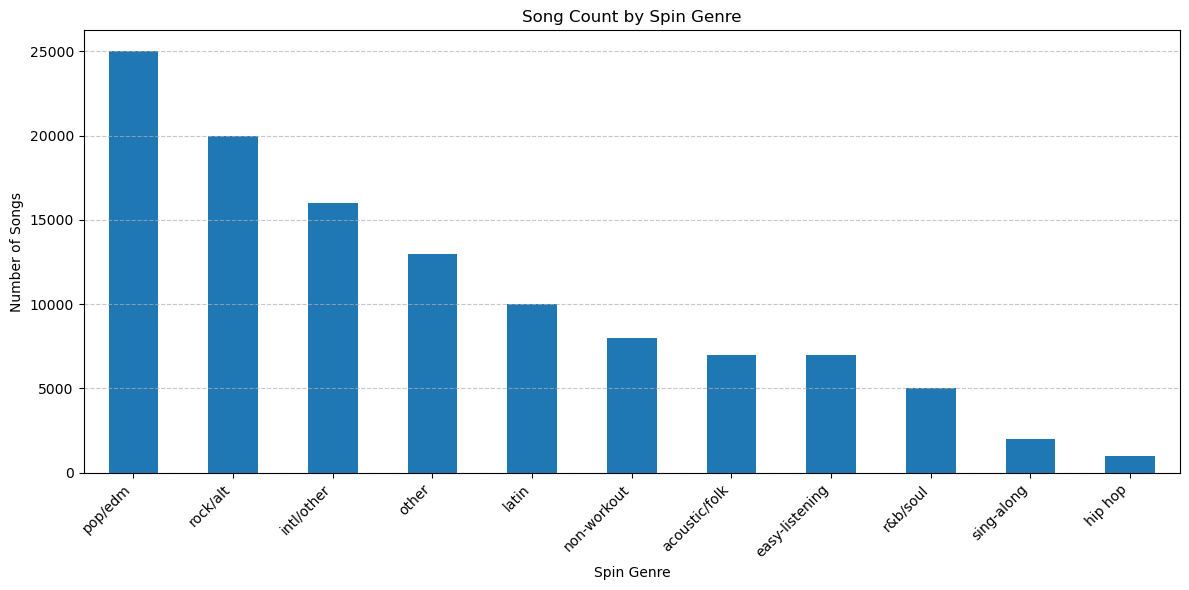

In [11]:
# Count number of songs per spin genre
genre_counts = df['spin_genre'].value_counts().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar')
plt.title('Song Count by Spin Genre')
plt.xlabel('Spin Genre')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


These ratios are being created for the following reasons:
- Tempo:Energy | Adds nuance to how songs feel energetically across tempo bands and is especially useful in teasing apart interval, sprint, and warm up.
- Energy:Danceability | Captures how intensely energetic a track is relative to how rhythmically fluid or danceable it is.
- Energy:Loudness | Captures relative “punch” or intensity per decibel. Could help distinguish interval from sprint or climb.
- Valence: Danceability | Valence is more emotional; danceability is more rhythmic. A high ratio could flag “happy but undanceable” songs — useful for warm up or non-workout.
- Energy:Acousticness | Inversely correlated. A high value means highly energetic & non-acoustic (think club/dance), great for sprint detection.
- Loudness: Instrumentalness | High loudness but low instrumentalness could flag vocals-heavy intense songs — separating sprint or climb from ambient/cooldown tracks.

In [12]:
# Create tempo:energy ratio
df['tempo_energy_ratio'] = df['tempo'] / (df['energy'] + 1e-5)

# Create energy:danceability ratio
df['energy_danceability_ratio'] = df['energy'] / (df['danceability'] + 1e-5)

# Energy:loudness ratio
df['energy_loudness_ratio'] = df['energy'] / (df['loudness'] + 1e-5)

# Valence:danceability ratio
df['valence_danceability_ratio'] = df['valence'] / (df['danceability'] + 1e-5)

# Energy:acousticness ratio
df['energy_acousticness_ratio'] = df['energy'] / (df['acousticness'] + 1e-5)

# Loudness:instrumentalness ratio
df['loudness_instrumentalness_ratio'] = df['loudness'] / (df['instrumentalness'] + 1e-5)


/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


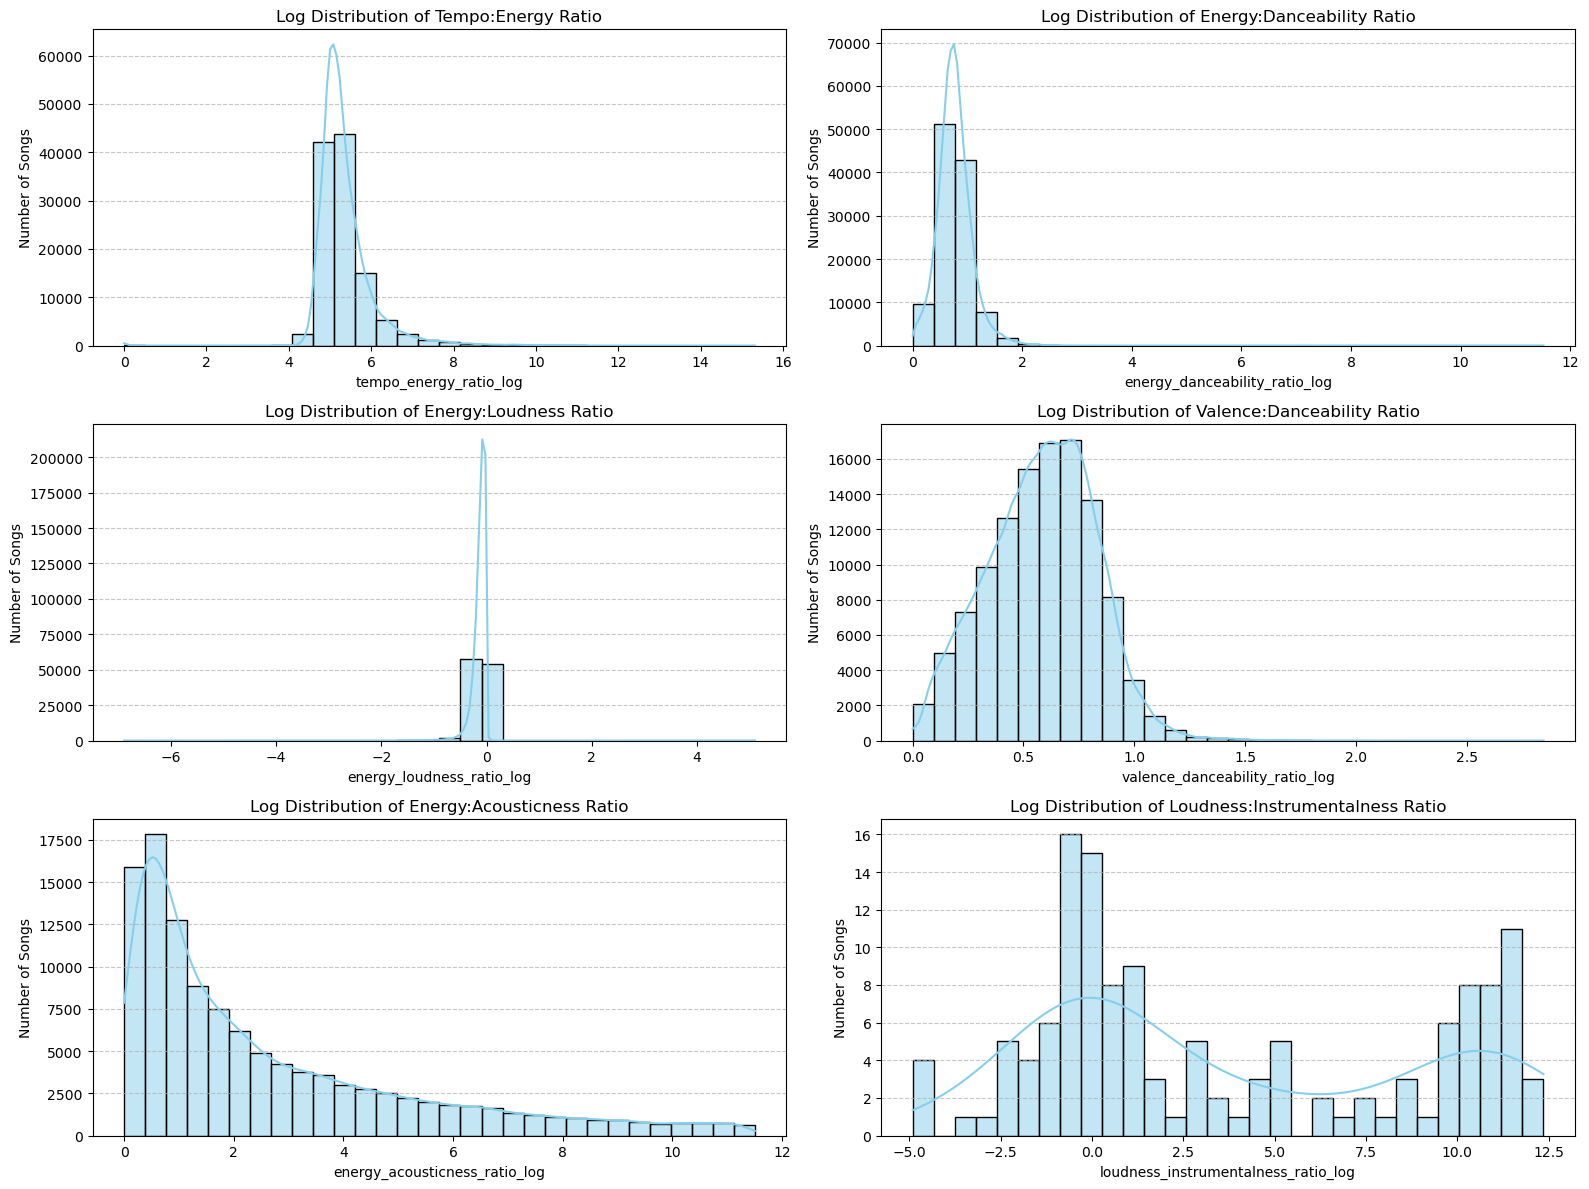

In [13]:
# Plot logged ratios
# Ratio creation function
def create_ratio_and_log(df, col1, col2, name):
    ratio_col = f'{name}_ratio'
    log_col = f'{name}_ratio_log'

    df[ratio_col] = df[col1] / (df[col2] + 1e-5)
    df[ratio_col] = df[ratio_col].replace([np.inf, -np.inf], np.nan)
    df[log_col] = np.log1p(df[ratio_col])
    df[log_col] = df[log_col].replace([np.inf, -np.inf], np.nan)
    
    return df

# Histogram plotting function that takes an Axes object
def plot_ratio_hist(ax, df, log_col, title=None, color='skyblue'):
    sns.histplot(df[log_col], bins=30, kde=True, color=color, ax=ax)
    ax.set_title(title or f'Distribution of {log_col}')
    ax.set_xlabel(log_col)
    ax.set_ylabel('Number of Songs')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Define all ratios
ratios_to_generate = [
    ('tempo', 'energy', 'tempo_energy'),
    ('energy', 'danceability', 'energy_danceability'),
    ('energy', 'loudness', 'energy_loudness'),
    ('valence', 'danceability', 'valence_danceability'),
    ('energy', 'acousticness', 'energy_acousticness'),
    ('loudness', 'instrumentalness', 'loudness_instrumentalness')
]

# Apply all ratios
for col1, col2, name in ratios_to_generate:
    df = create_ratio_and_log(df, col1, col2, name)

# Set up 3x2 subplot grid
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

# Plot each histogram
for ax, (_, _, name) in zip(axes, ratios_to_generate):
    log_col = f'{name}_ratio_log'
    title = f'Log Distribution of {name.replace("_", ":").title()} Ratio'
    plot_ratio_hist(ax, df, log_col, title)

plt.tight_layout()
plt.show()


In [14]:
# Create 'workout_type' (weighted scoring)
def assign_workout_type(row):
    # Non-workout conditions
    if (
        'white noise' in str(row['track_name']).lower()
        or 'nature sounds' in str(row['track_name']).lower()
        or row['speechiness'] > 0.66
        or row['duration_ms'] < 60 * 1000
        or row['duration_ms'] > 15 * 60 * 1000
        or row['acousticness'] > 0.9
    ):
        return 'non-workout'

    scores = {
        'sprint': 0,
        'interval': 0,
        'climb': 0,
        'warm up': 0,
        'cool down': 0
    }

    # Tempo
    if row['tempo'] > 140:
        scores['sprint'] += 2
    elif 125 < row['tempo'] <= 140:
        scores['interval'] += 2
    elif 110 < row['tempo'] <= 125:
        scores['climb'] += 2
    elif 85 <= row['tempo'] <= 110:
        scores['warm up'] += 2
    elif row['tempo'] < 85:
        scores['cool down'] += 2

    # Energy
    if row['energy'] > 0.9:
        scores['sprint'] += 2
    elif 0.8 < row['energy'] <= 0.9:
        scores['sprint'] += 1
        scores['interval'] += 2
    elif 0.55 < row['energy'] <= 0.8:
        scores['climb'] += 2
    elif row['energy'] < 0.5:
        scores['cool down'] += 3
        scores['warm up'] += 3

    # Valence
    if row['valence'] > 0.7:
        scores['sprint'] += 1
        scores['warm up'] += 1
    elif 0.5 <= row ['valence'] <= 0.7:
        scores['interval'] += 1
        scores['climb'] += 1
    elif row['valence'] < 0.5:
        scores['cool down'] += 3

    # Danceability
    if row['danceability'] > 0.65:
        scores['sprint'] += 1
        scores['interval'] += 1
        scores['climb'] += 1
    elif 0.4 <= row['danceability'] <= 0.65:
        scores['warm up'] += 1
    elif row['danceability'] < 0.4:
        scores['cool down'] += 1

    # Loudness
    if row['loudness'] > -5:
        scores['sprint'] += 1
    elif -10 <= row['loudness'] <= -5:
        scores['interval'] += 1
        scores['climb'] += 1
    elif row['loudness'] < -15:
        scores['cool down'] += 2

    # Instrumentalness
    if row['instrumentalness'] > 0.8:
        scores['cool down'] += 2
        scores['warm up'] += 1
    elif row['instrumentalness'] < 0.2:
        scores['sprint'] += 1
        scores['interval'] += 1

    # Speechiness (low values = music, high = spoken word)
    if 0.30 < row['speechiness'] <= 0.60:
        scores['cool down'] += 1
        scores['warm up'] += 1
    
    # Acousticness
    if 0.8 < row['acousticness'] >= 0.9:
        scores['cool down'] += 1


    return max(scores, key=scores.get) if max(scores.values()) > 0 else 'non-workout'


In [15]:
# # Creat 'workout_type' (simple)
# # Add column for workout type on subset
# def assign_workout_type(row):
#     tempo = row['tempo']
#     energy = row['energy']
#     valence = row['valence']
#     danceability = row['danceability']
    
#     if tempo > 130 and energy > 0.8 and valence > 0.3 and danceability > 0.55:
#         return 'sprint'
#     elif 120 <= tempo <= 130 and energy > 0.7:
#         return 'interval'
#     elif 110 <= tempo < 130 and 0.6 <= energy <= 0.8:
#         return 'climb'
#     elif 80 <= tempo < 110 and energy < 0.6 and valence > 0.3:
#         return 'warm up'
#     elif tempo < 100 and energy < 0.5 and valence > 0.4:
#         return 'cool down'
#     else:
#         return None  # leave ambiguous ones blank, this is where ML will come in

In [16]:
# Sample for heuristic labeling
sample_size = int(len(df) * 0.4) # taking 40% of the original dataset
sample_df = df.sample(sample_size, random_state=42).copy()

# Apply heuristic labeling function
sample_df['workout_type'] = sample_df.apply(assign_workout_type, axis=1)

# Filter labeled rows only
training_data = sample_df.dropna(subset=['workout_type'])

print("Labeled rows:", len(training_data))
print(training_data['workout_type'].value_counts())

Labeled rows: 45600
workout_type
sprint         12772
cool down       9758
climb           8001
interval        7715
non-workout     4205
warm up         3149
Name: count, dtype: int64


In [17]:
# Inspect training data
# Filter to genre 
pop_training_data = training_data[training_data['track_genre'] == 'pop']

# Show 5 random pop songs per workout type
for workout in pop_training_data['workout_type'].unique():
    print(f"\n{workout.upper()} examples:")
    display(
        pop_training_data[
            pop_training_data['workout_type'] == workout
        ][['track_name', 'artists', 'tempo', 'energy', 'valence', 'danceability']].sample(3, random_state=42)
    )



SPRINT examples:


,track_name,artists,tempo,energy,valence,danceability
81482,Orasaadha - Madras Gig,Vivek - Mervin,159.906,0.776,0.606,0.587
81705,Leave the Door Open,Bruno Mars;Anderson .Paak;Silk Sonic,148.088,0.616,0.719,0.586
81025,Lemonade,Diljit Dosanjh,143.998,0.744,0.783,0.789



CLIMB examples:


,track_name,artists,tempo,energy,valence,danceability
81721,Skate,Bruno Mars;Anderson .Paak;Silk Sonic,112.027,0.598,0.698,0.708
81177,Ik Tera,Maninder Buttar,93.029,0.712,0.490,0.826
81582,Feliz Cumpleaños Ferxxo,Feid,94.999,0.573,0.563,0.865



INTERVAL examples:


,track_name,artists,tempo,energy,valence,danceability
81361,FRIENDS,Marshmello;Anne-Marie,95.079,0.880,0.534,0.626
81349,All Around The World,Justin Bieber;Ludacris,128.009,0.816,0.798,0.694
81208,I Like Me Better,Lauv,91.970,0.505,0.419,0.752



WARM UP examples:


,track_name,artists,tempo,energy,valence,danceability
81518,Dariya,Arko,98.936,0.424,0.352,0.581
81086,Tera Ban Jaunga,Akhil Sachdeva;Tulsi Kumar,93.950,0.530,0.397,0.605
81605,Ek Raat,Vilen,90.024,0.534,0.302,0.645



COOL DOWN examples:


,track_name,artists,tempo,energy,valence,danceability
81651,It's You,Ali Gatie,95.971,0.463,0.3970,0.732
81616,I'm Not The Only One,Sam Smith,81.997,0.487,0.4560,0.684
81549,Dangerous - David Guetta Banging Remix,David Guetta;Sam Martin,128.004,0.931,0.0825,0.698



NON-WORKOUT examples:


,track_name,artists,tempo,energy,valence,danceability
81830,Have Yourself A Merry Little Christmas,Sam Smith,75.25,0.178,0.344,0.438
81832,Have Yourself A Merry Little Christmas,Sam Smith,75.25,0.178,0.344,0.438
81843,Have Yourself A Merry Little Christmas,Sam Smith,75.25,0.178,0.344,0.438


/var/folders/6j/5730h4y12159227rqs8wg2r80000gn/T/ipykernel_80229/692780682.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/var/folders/6j/5730h4y12159227rqs8wg2r80000gn/T/ipykernel_80229/692780682.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/var/folders/6j/5730h4y12159227rqs8wg2r80000gn/T/ipykernel_80229/692780682.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


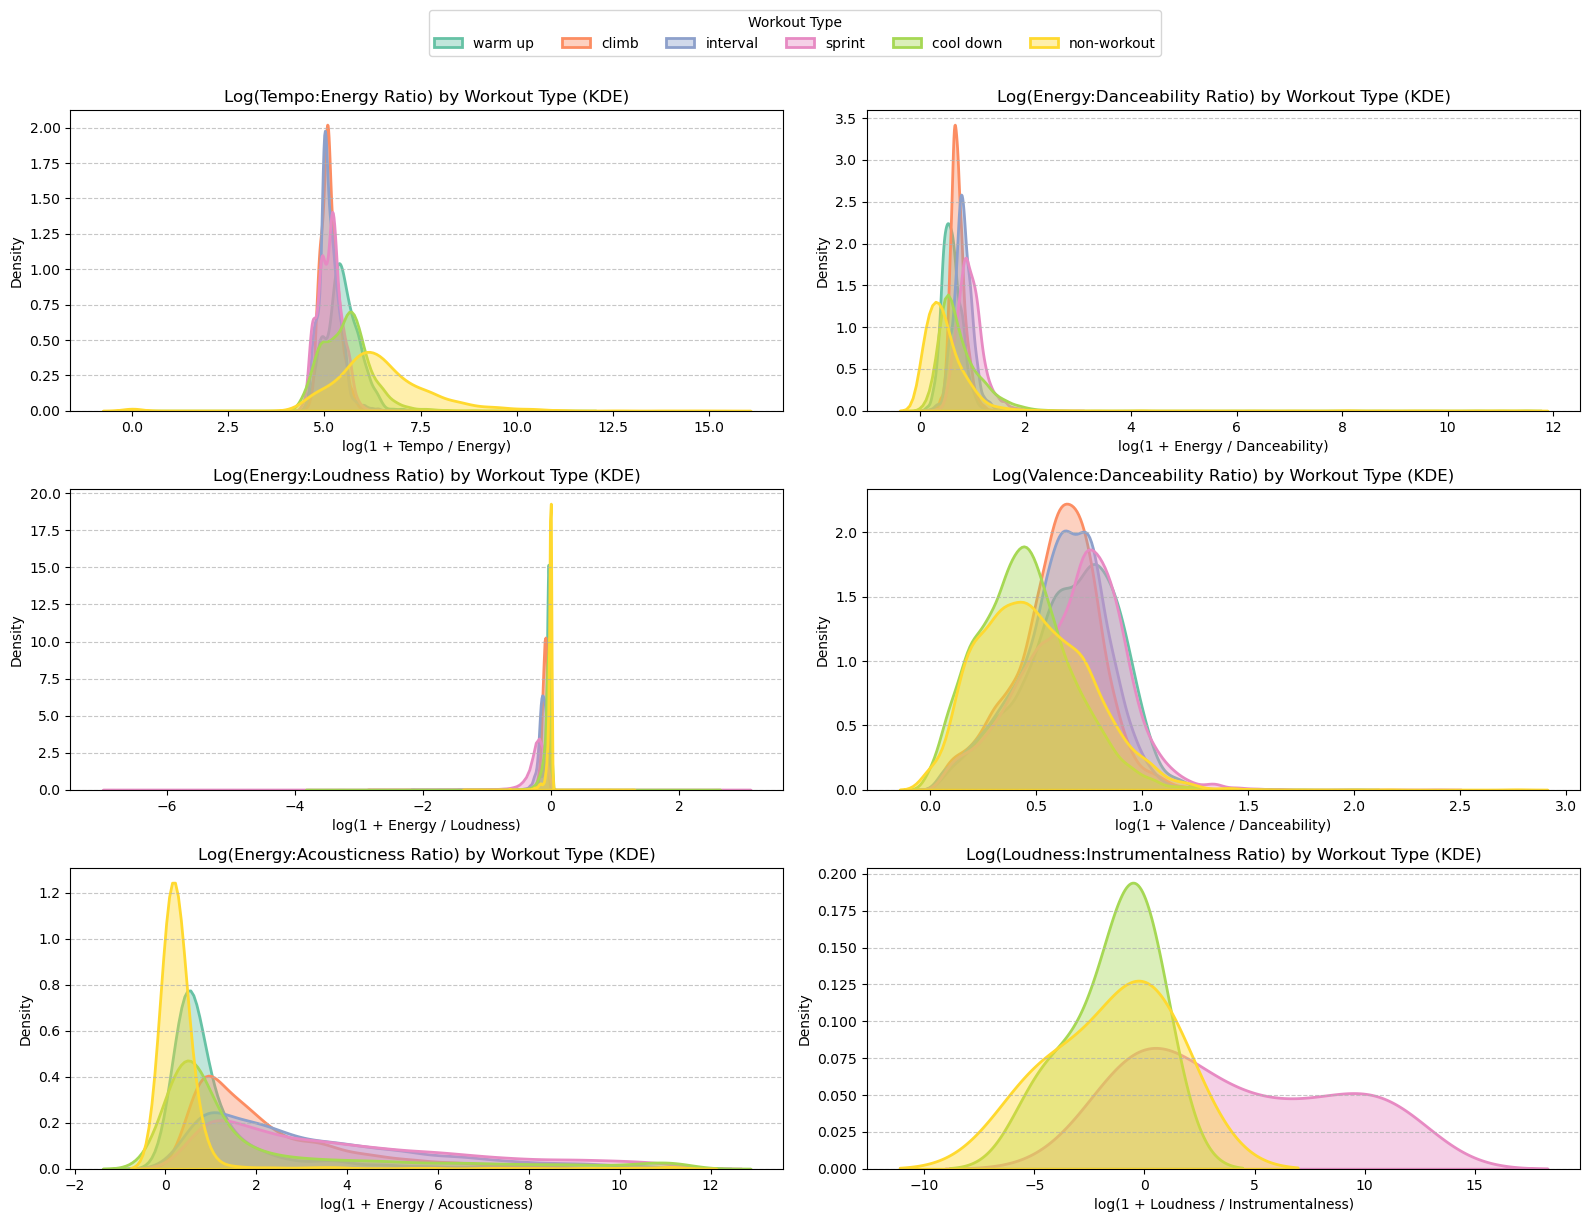

In [18]:
#Plot ratio features by workout type
def plot_kde_by_workout(ax, data, feature, title, xlabel, workouts=None, colors=None):
    if workouts is None:
        workouts = ['warm up', 'climb', 'interval', 'sprint', 'cool down', 'non-workout']
    
    if colors is None:
        colors = sns.color_palette('Set2', len(workouts))

    for workout, color in zip(workouts, colors):
        subset = data[data['workout_type'] == workout]
        sns.kdeplot(
            subset[feature],
            ax=ax,
            label=workout,
            fill=True,
            alpha=0.4,
            linewidth=2,
            color=color
        )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Density')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Features to plot
plot_features = [
    ('tempo_energy_ratio_log', 'Log(Tempo:Energy Ratio) by Workout Type (KDE)', 'log(1 + Tempo / Energy)'),
    ('energy_danceability_ratio_log', 'Log(Energy:Danceability Ratio) by Workout Type (KDE)', 'log(1 + Energy / Danceability)'),
    ('energy_loudness_ratio_log', 'Log(Energy:Loudness Ratio) by Workout Type (KDE)', 'log(1 + Energy / Loudness)'),
    ('valence_danceability_ratio_log', 'Log(Valence:Danceability Ratio) by Workout Type (KDE)', 'log(1 + Valence / Danceability)'),
    ('energy_acousticness_ratio_log', 'Log(Energy:Acousticness Ratio) by Workout Type (KDE)', 'log(1 + Energy / Acousticness)'),
    ('loudness_instrumentalness_ratio_log', 'Log(Loudness:Instrumentalness Ratio) by Workout Type (KDE)', 'log(1 + Loudness / Instrumentalness)')
]

# Create 3x2 subplot grid
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()  # Flatten to easily iterate

# Plot all features
for ax, (feature, title, xlabel) in zip(axes, plot_features):
    plot_kde_by_workout(ax, training_data, feature, title, xlabel)

# Final touches
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Workout Type", loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.02))
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for legend
plt.show()


- Tempo:Energy Ratio shows most workout types clustered between 5 and 6. Non-workout has a greater span. 
- Energy:Danceability Ratio again shows clustering of workout types. It may help separate higher intensity workouts (sprint & interval) from others. 
- Energy:Loudness Ratio shows all classes tightly clustered at 0. Minimal discriminatory weight, we'll drop this from the pipeline features.
- Valence:Danceability Ratio shows moderate overlap between all types. However, warm-up, cool-down, and non-workout seem slightly skewed left compared to more intense workouts (like sprint and interval). Valence (emotional positivity) may be lower relative to danceability in non-workout or cool-down music.
- Energy:Acousticness Ratio shows warm-up, cool down, and non-workout all skewed further left. Could be effective distinguishing low-energy, more acoustic tracks (used for cool down or non-workout) from high-energy, synthetic workout tracks. 
- Lots of missing values for Loudness:Instrumentalness which won't help separate workout classifications. 

## Pipeline Build + Model Deployment

In [19]:
# Split data
# # Using the manual label column as the primary then filling in with workout_type
# training_data.loc[:, 'label'] = training_data['manual_label'].fillna(training_data['workout_type'])

# Define features
numeric_features = [
    'tempo', 'energy', 'danceability', 'valence', 'loudness', 'acousticness', 
    'instrumentalness', 'speechiness', 'tempo_energy_ratio_log', 'energy_danceability_ratio_log',
    'valence_danceability_ratio_log', 'energy_acousticness_ratio_log']
categorical_features = ['track_genre']
features = numeric_features + categorical_features

X = training_data[features]
y = training_data['workout_type'] 

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data
X_train, X_test, y_train_enc, y_test_enc = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.3, random_state=42)

In [20]:
# Define preprocessor: scale numeric, one-hot encode categorical
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', random_state=42, n_jobs=-1),
    'SVM': SVC(probability=True, kernel='rbf', random_state=42)
}

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('clf', model)
    ])

    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_enc)

    # Fit the pipeline
    pipeline.fit(X_train, y_train_enc, clf__sample_weight=sample_weights)

    # Make predictions (this part was missing)
    y_pred_enc = pipeline.predict(X_test)
    y_pred = label_encoder.inverse_transform(y_pred_enc)
    y_test_decoded = label_encoder.inverse_transform(y_test_enc)

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test_decoded, y_pred))



Random Forest Classification Report:
              precision    recall  f1-score   support

       climb       0.94      0.96      0.95      2400
   cool down       0.95      0.96      0.95      2927
    interval       0.95      0.95      0.95      2315
 non-workout       1.00      0.93      0.96      1261
      sprint       0.96      0.97      0.96      3832
     warm up       0.92      0.87      0.90       945

    accuracy                           0.95     13680
   macro avg       0.95      0.94      0.95     13680
weighted avg       0.95      0.95      0.95     13680


XGBoost Classification Report:
              precision    recall  f1-score   support

       climb       0.99      0.99      0.99      2400
   cool down       0.98      0.98      0.98      2927
    interval       0.98      0.99      0.98      2315
 non-workout       0.99      0.93      0.96      1261
      sprint       0.98      0.99      0.99      3832
     warm up       0.97      0.99      0.98       945

    acc

In [21]:
# Stratified K-Fold

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(eval_metric='mlogloss', random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_idx, test_idx in cv.split(X, y_encoded):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y_encoded[train_idx], y_encoded[test_idx]

    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_cv)

    pipeline.fit(X_train_cv, y_train_cv, clf__sample_weight=sample_weights)
    y_pred_cv = pipeline.predict(X_test_cv)

    score = f1_score(y_test_cv, y_pred_cv, average='macro')
    scores.append(score)

print("Stratified K-Fold F1 Macro Scores:", scores)
print("Average F1 Macro Score:", np.mean(scores))


Stratified K-Fold F1 Macro Scores: [0.980553775519685, 0.9813224465477973, 0.9807136122221314, 0.9773609739341321, 0.9806944359453565]
Average F1 Macro Score: 0.9801290488338206


In [22]:
# RandomizedSearchCV
# ColumnTransformer setup
numeric_features = [
    'tempo', 'energy', 'danceability', 'valence', 'loudness', 'acousticness', 
    'instrumentalness', 'speechiness', 'tempo_energy_ratio_log', 'energy_danceability_ratio_log',
    'valence_danceability_ratio_log', 'energy_acousticness_ratio_log']
categorical_features = ['track_genre']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(eval_metric='mlogloss', random_state=42))
])

# Parameter space
param_dist = {
    'clf__n_estimators': [100, 200, 250, 300],
    'clf__max_depth': [3, 5, 7, 9, 10],
    'clf__learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2, 0.3],
    'clf__subsample': [0.5, 0.6, 0.7, 0.8, 1.0],
    'clf__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 1.0],
    # extra additions to improve CV
    'clf__gamma': [0, 0.1, 0.3, 0.5],
    'clf__min_child_weight': [1, 3, 5]
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run randomized search
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=cv,
    scoring='f1_macro',
    verbose=0,
    n_jobs=-1,
    random_state=42
)

# Fit
random_search.fit(X_train, y_train_enc)

# Best model
print("Best params:", random_search.best_params_)
print("Best F1 Macro Score:", random_search.best_score_)


Best params: {'clf__subsample': 0.6, 'clf__n_estimators': 250, 'clf__min_child_weight': 1, 'clf__max_depth': 7, 'clf__learning_rate': 0.2, 'clf__gamma': 0.3, 'clf__colsample_bytree': 0.8}
Best F1 Macro Score: 0.9794901009585164


Interesting that this is sliiiiiightly lower than the XGBoost CV score. I fear we've reached a performance ceiling. Thankfully they're both hovering around .98, which is an excellent result either way. 

In [23]:
# Save model
import joblib
joblib.dump(random_search.best_estimator_, 'workout_classifier.pkl')

['workout_classifier.pkl']

<Figure size 1000x800 with 0 Axes>

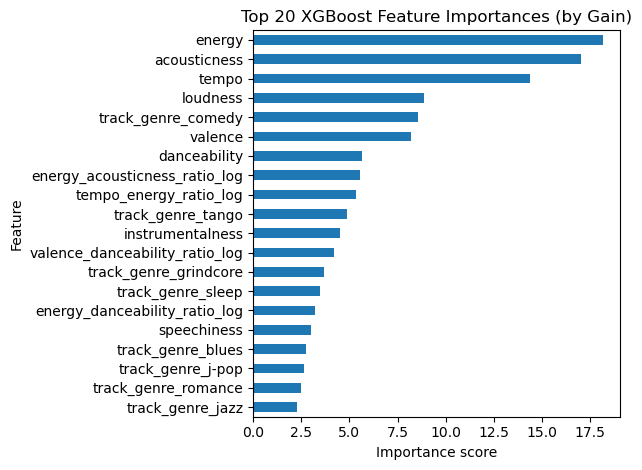

In [24]:
# Visualize feature importance

# Load trained pipeline and extract steps
pipeline = joblib.load('workout_classifier.pkl')
model = pipeline.named_steps['clf']
preprocessor = pipeline.named_steps['preprocessor']

# Get feature names
num_feats = numeric_features
cat_feats = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([num_feats, cat_feats])

# Map feature importances
booster = model.get_booster()
importance = booster.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': [feature_names[int(f[1:])] for f in importance],
    'Gain': list(importance.values())
}).sort_values(by='Gain', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
importance_df.head(20).plot(kind='barh', x='Feature', y='Gain', legend=False)
plt.title("Top 20 XGBoost Feature Importances (by Gain)")
plt.xlabel("Importance score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

 98%|===================| 1177/1200 [04:27<00:05]        

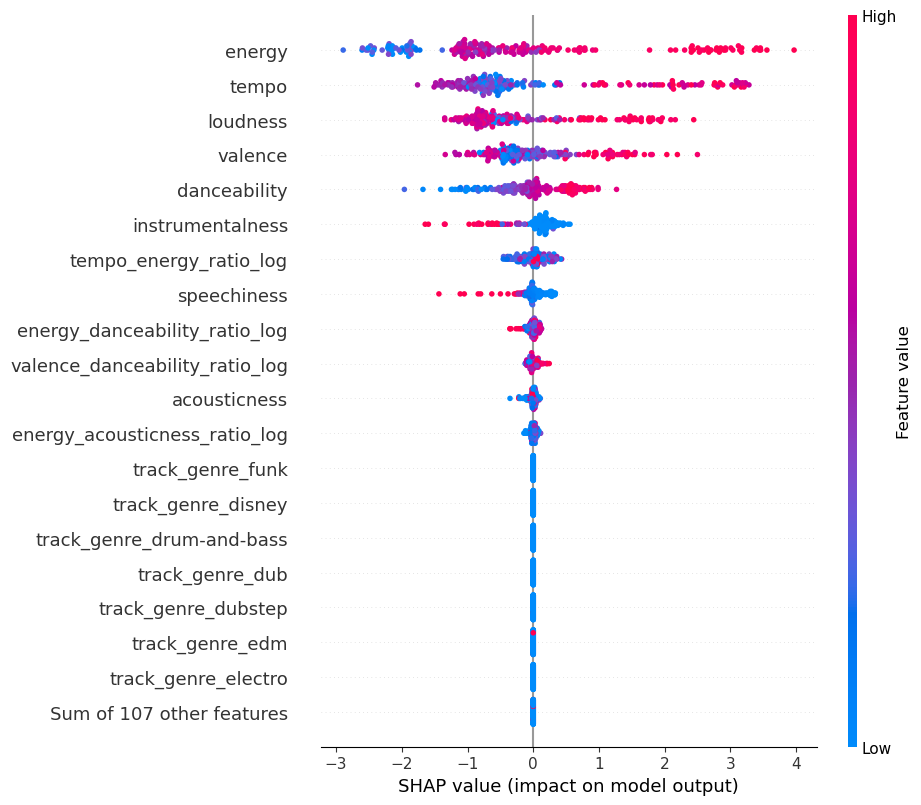

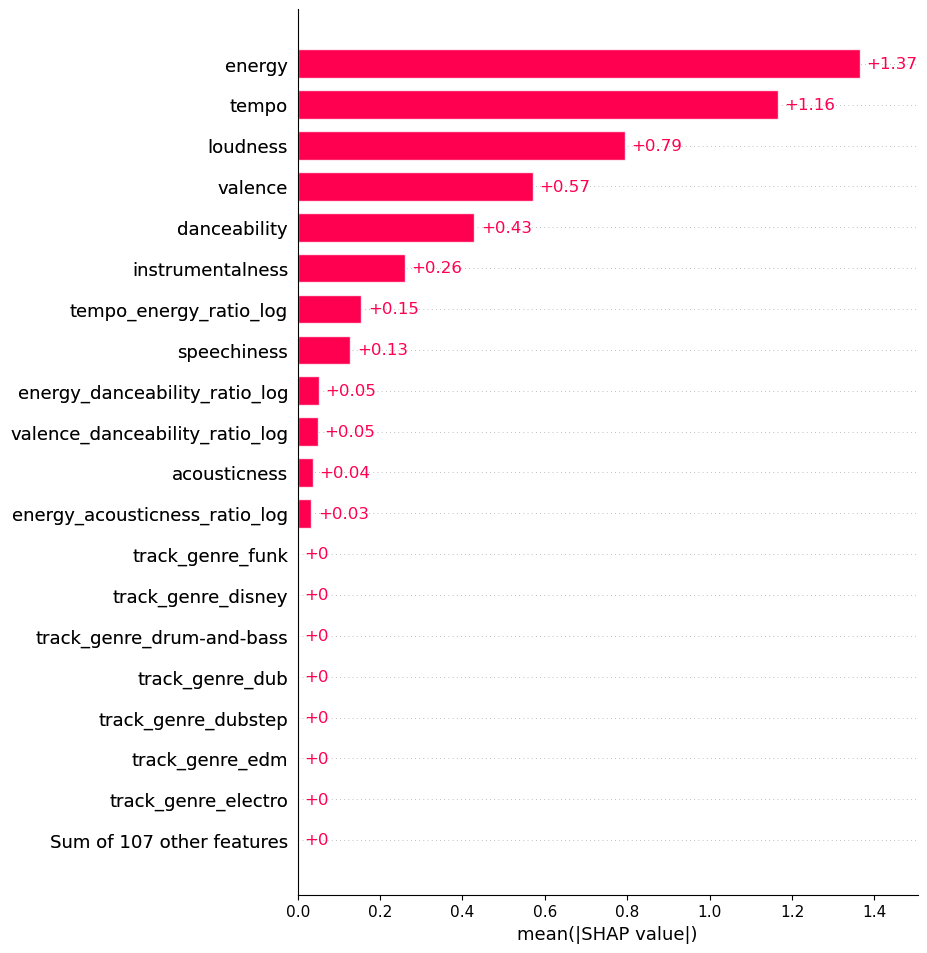

In [25]:
# SHAP
# Load the pipeline again
pipeline = joblib.load('workout_classifier.pkl')
model = pipeline.named_steps['clf']
preprocessor = pipeline.named_steps['preprocessor']

# Prepare transformed training data
X_train_transformed = preprocessor.transform(X_train).toarray()

# Get feature names after transformation
num_feats = numeric_features
cat_feats = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([num_feats, cat_feats])

# SHAP Explainer for XGBoost
explainer = shap.Explainer(model, X_train_transformed, feature_names=feature_names)

# Compute SHAP values for a sample
shap_values = explainer(X_train_transformed[:200])

# Plot chart
class_name = 'sprint'  # Change this to another workout type as needed!
class_index = list(label_encoder.classes_).index(class_name)

# Extract SHAP values for this class
shap_values_class = shap_values[..., class_index]

# Beeswarm plot (local interpretability)
shap.plots.beeswarm(shap_values_class, max_display=20)

# Bar plot (global importance)
shap.plots.bar(shap_values_class, max_display=20)

<Figure size 1000x700 with 0 Axes>

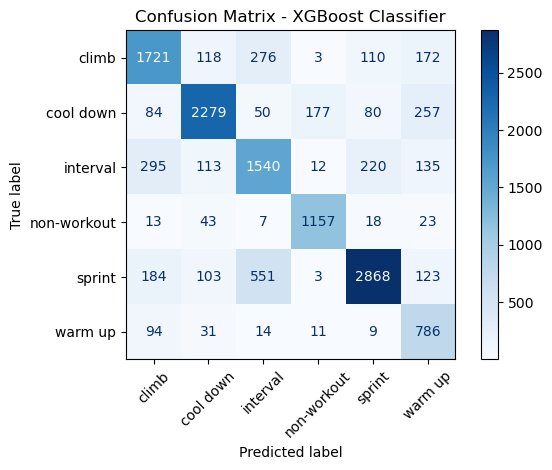

In [26]:
# Generate the confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred, labels=label_encoder.classes_)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Plot it
plt.figure(figsize=(10, 7))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - XGBoost Classifier")
plt.grid(False)
plt.tight_layout()
plt.show()


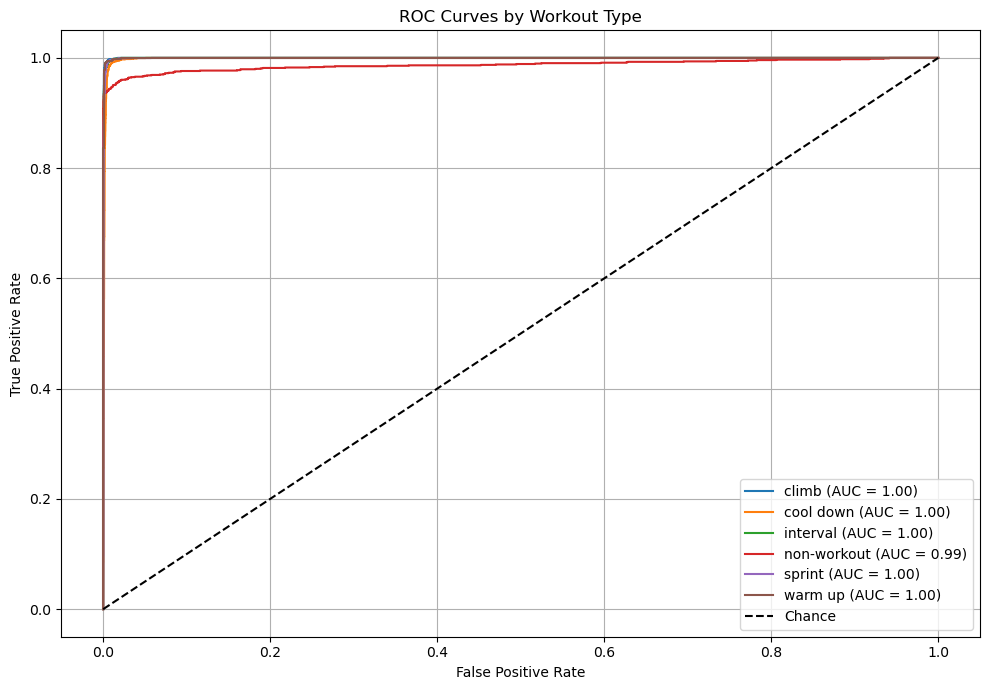

In [27]:
# ROC-AUC

# Use the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Binarize the labels for multi-class ROC
y_test_binarized = label_binarize(y_test_enc, classes=np.arange(len(label_encoder.classes_)))
y_score = best_model.predict_proba(X_test)

# Create ROC curve for each class
n_classes = y_test_binarized.shape[1]
plt.figure(figsize=(10, 7))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.title("ROC Curves by Workout Type")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Results show clear separation between classes; the model is highly confident at distinguishing workout types. Non-workout AUC is slightly lower, but expected due to the nature of this class. 

In [28]:
# Use the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Apply model to unlabeled songs
unlabeled_songs = df[~df['track_id'].isin(training_data['track_id'])].copy()

# Predict labels using the best model
X_unlabeled = unlabeled_songs[X_train.columns]
unlabeled_songs['workout_type'] = best_model.predict(X_unlabeled)
unlabeled_songs['workout_type'] = label_encoder.inverse_transform(unlabeled_songs['workout_type'])

# Filter out non-workout tracks
usable_songs = unlabeled_songs[unlabeled_songs['workout_type'] != 'non-workout']


In [29]:
# Sample predictions
usable_songs[['track_name', 'artists', 'track_genre', 'spin_genre', 'workout_type', 'tempo', 'energy', 'danceability', 'valence', 'loudness', 'acousticness', 'instrumentalness', 'speechiness']].sample(5)


,track_name,artists,track_genre,spin_genre,workout_type,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness
49957,This Is Home,Wildstylez;Coone;Cimo Fränkel,hardstyle,other,sprint,147.993,0.936,0.558,0.396,-4.025,0.00224,0.000136,0.0500
70529,獨角戲,Valen Hsu,mandopop,intl/other,cool down,171.814,0.350,0.353,0.205,-14.231,0.76300,0.000004,0.0402
102456,Bas Yahan,Vaibhav Malhotra,songwriter,acoustic/folk,cool down,124.897,0.421,0.565,0.193,-8.681,0.77200,0.000000,0.0342
68630,No Te Va,Joey Montana;Lalo Ebratt,latino,latin,sprint,96.983,0.934,0.844,0.647,-1.223,0.17000,0.000121,0.0780
62107,まつり,Fujii Kaze,j-pop,intl/other,climb,97.025,0.731,0.663,0.356,-7.335,0.00892,0.050200,0.0338


## Workout Type Feature Distribution

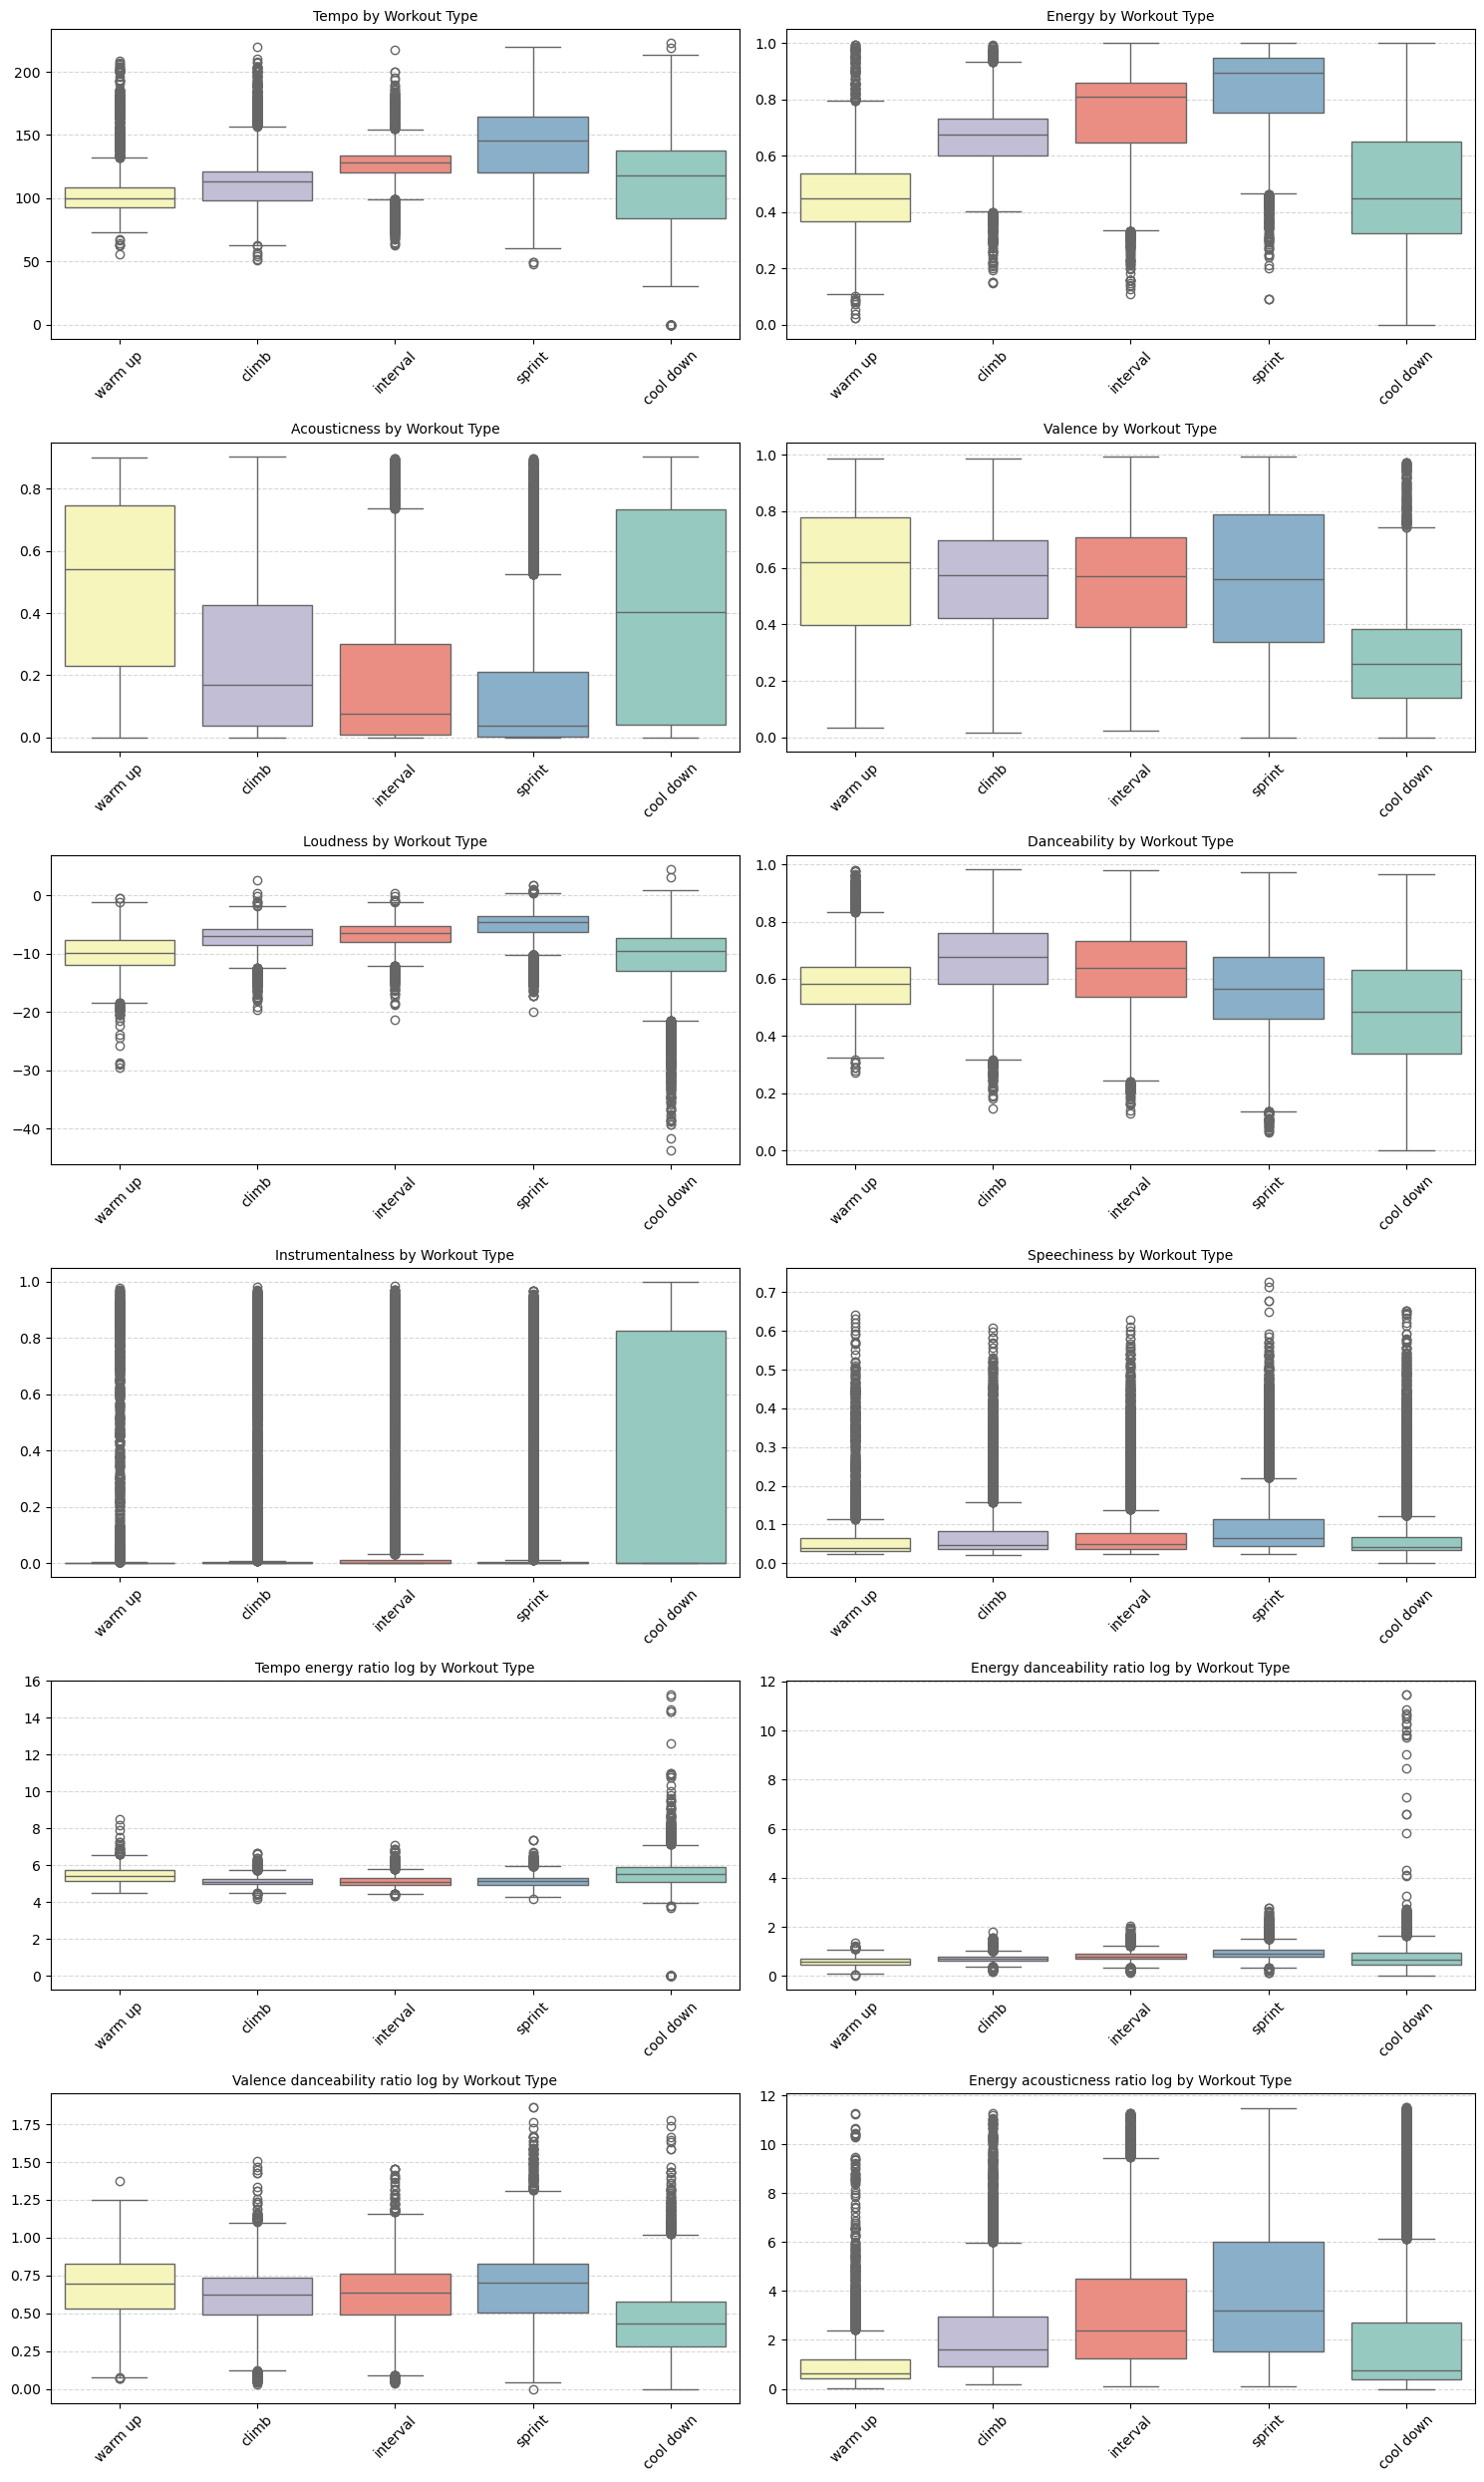

In [30]:
# Features to visualize + order
features = [
    'tempo', 'energy', 'acousticness', 'valence', 'loudness', 'danceability', 
    'instrumentalness', 'speechiness', 'tempo_energy_ratio_log', 'energy_danceability_ratio_log',
    'valence_danceability_ratio_log', 'energy_acousticness_ratio_log']
workout_order = ['warm up', 'climb', 'interval', 'sprint', 'cool down']

# Set up the subplot grid
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 25))
axes = axes.flatten()  # flatten to easily iterate

# Loop through each feature and create a boxplot grouped by predicted workout type
for idx, feature in enumerate(features):
    ax = axes[idx]
    sns.boxplot(
        data=usable_songs,
        x='workout_type',
        y=feature,
        hue='workout_type',
        palette='Set3',
        order=workout_order,
        ax=ax,
        legend=False
    )
    ax.set_title(f'{feature.replace("_", " ").capitalize()} by Workout Type', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Hide any empty subplots if features < total grid size
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

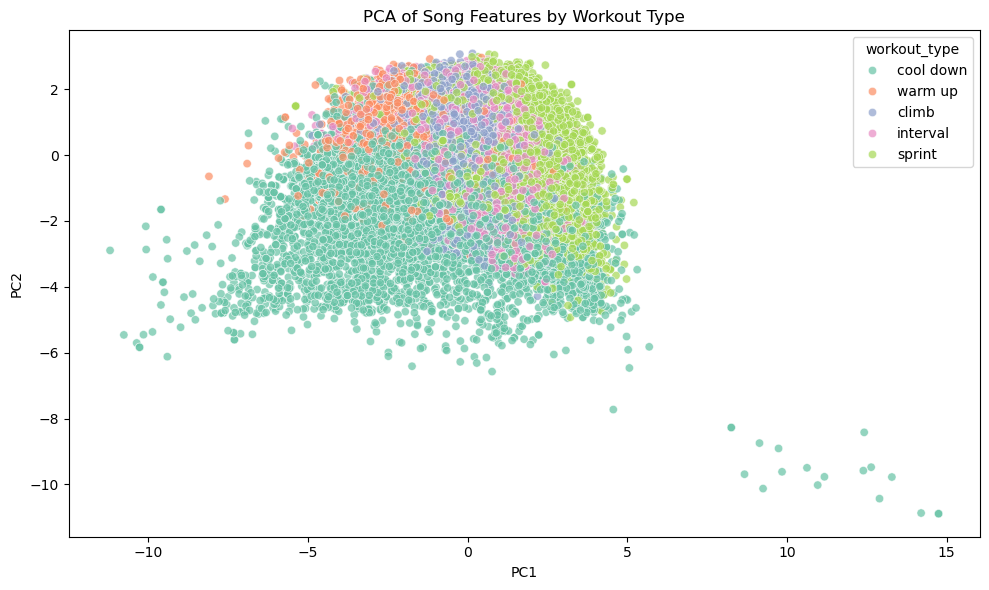

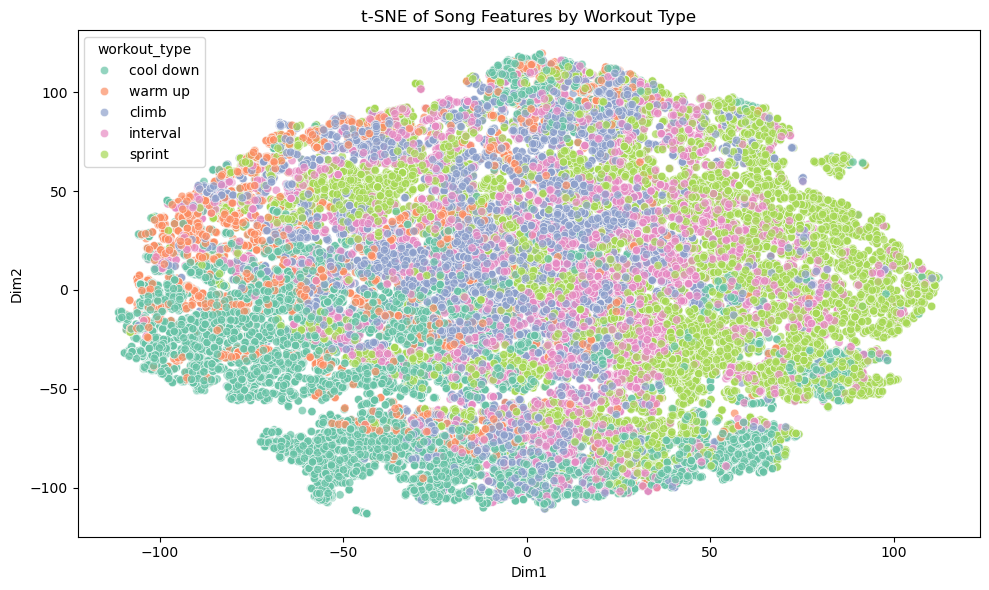

In [31]:
# PCA and t-SNE test
# Select features to embed
features = [
    'tempo', 'energy', 'danceability', 'valence', 'loudness', 'acousticness', 
    'instrumentalness', 'speechiness', 'tempo_energy_ratio_log', 'energy_danceability_ratio_log',
    'valence_danceability_ratio_log', 'energy_acousticness_ratio_log']
X = usable_songs[features].dropna()
y = usable_songs.loc[X.index, 'workout_type']

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA (2D)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['workout_type'] = y.values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='workout_type', palette='Set2', alpha=0.7)
plt.title("PCA of Song Features by Workout Type")
plt.tight_layout()
plt.show()

# t-SNE (2D)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
tsne_result = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame(tsne_result, columns=['Dim1', 'Dim2'])
tsne_df['workout_type'] = y.values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='workout_type', palette='Set2', alpha=0.7)
plt.title("t-SNE of Song Features by Workout Type")
plt.tight_layout()
plt.show()


PCA
- Lots of overlap here. Indicates songs share similar feature profiles.
- Cool down does seem to be skewed left and sprint skewed right. Likely that PC1 encodes some combination of energy, tempo, and/or acousticness.
- Cool down dominates sparse regions, meaning it has the widest variance. 
- Confirms that XGBoost's supervised learning is best to make sense of these patterns. 

t-SNE
- Shows more distinct regions of local grouping than PCA (sprint being the most distinct) 
- Warm up and cool down are less distinct than sprint, but still show consistent trends in how t-SNE clusters them. 
- Climb and interval are the most entangled, though are arguably closest in classification.	

In [32]:
# See how much each original feature contributes to PC1 and PC2
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)
print(loadings)


                                     PC1       PC2
tempo                           0.087690 -0.010522
energy                          0.477808  0.073083
danceability                   -0.077981  0.371040
valence                         0.043874  0.593677
loudness                        0.373271  0.204449
acousticness                   -0.395600  0.082513
instrumentalness               -0.002724 -0.366977
speechiness                     0.075764  0.073350
tempo_energy_ratio_log         -0.391572 -0.093049
energy_danceability_ratio_log   0.375033 -0.215912
valence_danceability_ratio_log  0.102157  0.462012
energy_acousticness_ratio_log   0.387314 -0.216874


- PC1 is clearly an “intensity” axis.
- PC2 is an “emotional tone / accessibility” axis.

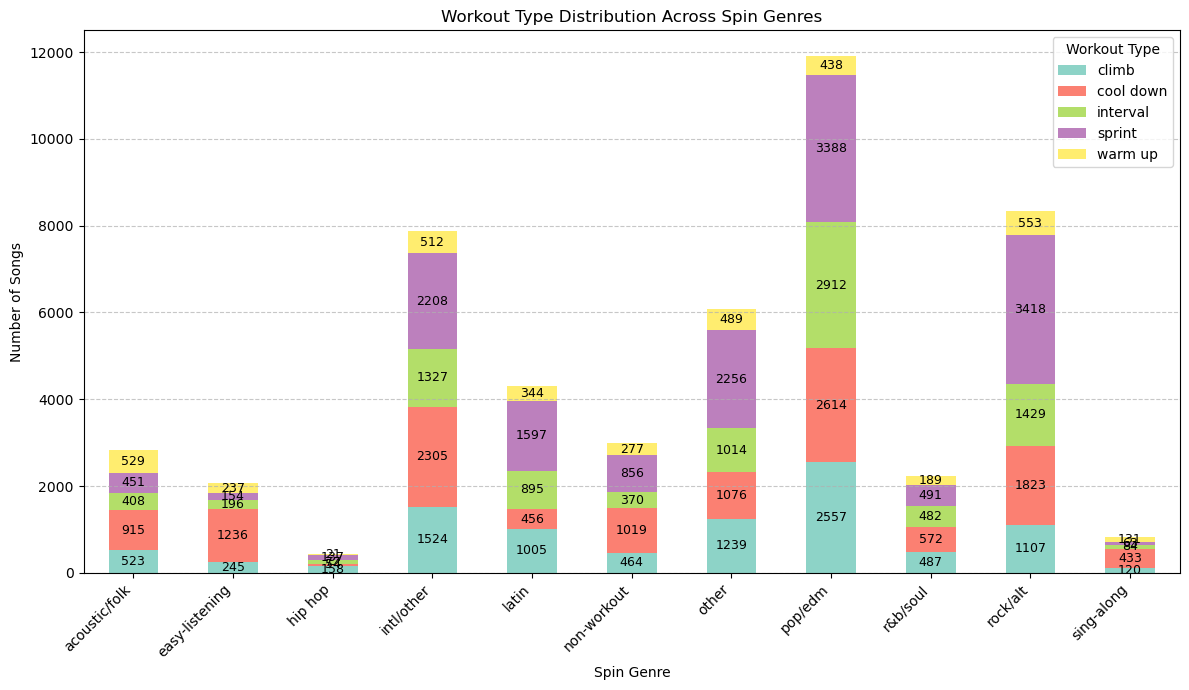

In [33]:
# Plot workout type by genre
# Create pivot table
genre_label_counts = usable_songs.pivot_table(
    index='spin_genre',
    columns='workout_type',
    aggfunc='size',
    fill_value=0
)

# Plot stacked bar chart
ax = genre_label_counts.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='Set3')

# Add value labels
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.annotate(
                f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                ha='center',
                va='center',
                fontsize=9,
                color='black'
            )

# Format chart
plt.title("Workout Type Distribution Across Spin Genres")
plt.xlabel("Spin Genre")
plt.ylabel("Number of Songs")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Workout Type')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

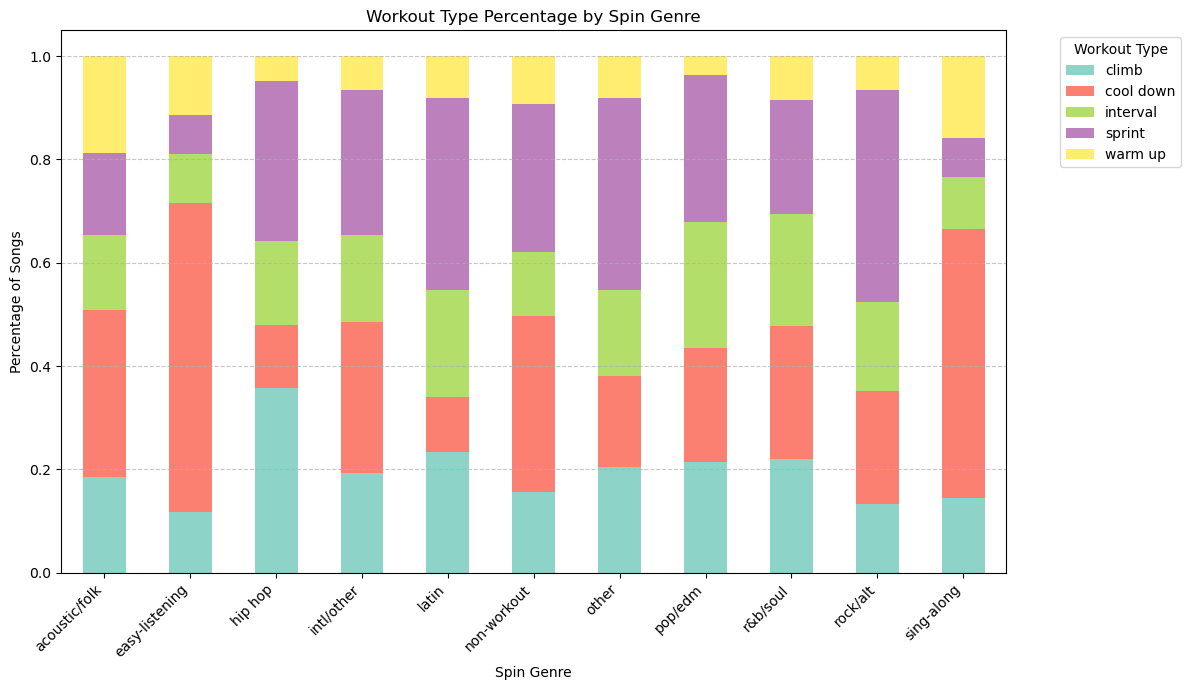

In [34]:
# Workout Type Percentage by Spin Genre
# Create pivot table of counts
genre_label_counts = usable_songs.pivot_table(
    index='spin_genre',
    columns='workout_type',
    aggfunc='size',
    fill_value=0
)

# Normalize each row to get percentages
genre_label_percent = genre_label_counts.div(genre_label_counts.sum(axis=1), axis=0)

# Plot
genre_label_percent.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='Set3')

plt.title("Workout Type Percentage by Spin Genre")
plt.xlabel("Spin Genre")
plt.ylabel("Percentage of Songs")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Workout Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Playlist building

In [35]:
# Constant Variables
# Shared constants
playlist_structures = {
    'balanced': ['warm up', 'interval', 'sprint', 'interval', 'climb',
                 'interval', 'sprint', 'interval', 'climb', 'cool down'],
    'speed': ['warm up', 'interval', 'sprint', 'interval', 'warm up',
              'interval', 'sprint', 'interval', 'sprint', 'cool down'],
    'climb': ['warm up', 'interval', 'climb', 'interval', 'climb',
              'warm up', 'climb', 'interval', 'climb', 'cool down'],
    'recovery': ['warm up', 'interval', 'interval', 'cool down', 'interval',
                 'interval', 'cool down', 'interval', 'cool down', 'cool down']
}

spin_genres = [
    'pop/edm', 'rock/alt', 'hip hop', 'r&b/soul', 'acoustic/folk', 
    'latin', 'easy-listening', 'intl/other', 'sing-along'
]

# Shuffle songs once and reuse
usable_songs_shuffled = usable_songs.sample(frac=1, random_state=42).copy()

# Utility: Song finder
def find_song(df, workout_type, used_tracks, popularity_thresholds=[70, 55, 30, 10]):
    for threshold in popularity_thresholds:
        match = df[
            (df['workout_type'] == workout_type) &
            (df['popularity'] >= threshold) &
            (~df['track_name'].isin(used_tracks))
        ]
        if not match.empty:
            return match.sample(1).copy()
    return pd.DataFrame()

# Utility: Playlist display
def display_playlist(playlist, title=None):
    if title:
        print(f"\n{title}\n{'=' * len(title)}")

    # Instruction mapping
    instruction_map = {
        'warm up': 'Low intensity. Cadence 80–100 RPM, light resistance. Focus on warming up.',
        'climb': 'Moderate to high intensity. Cadence 60–75 RPM, heavy resistance. Stay seated or alternate standing.',
        'interval': 'Alternating intensity. Cadence 90–100 RPM (sprint), then 60–70 RPM (recover). Moderate resistance.',
        'sprint': 'High intensity. Cadence 100+ RPM, light to moderate resistance. Go all out during the chorus!',
        'cool down': 'Very low intensity. Cadence 70–80 RPM, very light resistance. Focus on recovery.',
    }

    display_df = playlist[['workout_type', 'track_name', 'artists', 'track_genre', 'tempo', 'energy', 
                           'danceability', 'valence', 'loudness', 'acousticness', 'instrumentalness', 'speechiness']].copy()
    
    # Add instructions and Spotify URL
    display_df['instructions'] = playlist['workout_type'].map(instruction_map)
    display_df['spotify_url'] = "https://open.spotify.com/track/" + playlist['track_id']

    # Reorder columns to move 'instructions' after 'workout_type'
    cols = display_df.columns.tolist()
    cols.insert(1, cols.pop(cols.index('instructions')))  # Move 'instructions' to index 1
    display_df = display_df[cols]

    # Display
    display(display_df)

    # Total time
    total_ms = playlist['duration_ms'].sum()
    total_min, total_sec = divmod(int(total_ms / 1000), 60)
    print(f"Total duration: {total_min} min {total_sec} sec")


In [36]:
# Combine datasets
usable_songs.loc[:, 'source'] = 'predicted'
training_data.loc[:, 'source'] = 'labeled'

full_data = pd.concat([training_data, usable_songs], ignore_index=True)

/var/folders/6j/5730h4y12159227rqs8wg2r80000gn/T/ipykernel_80229/1333994168.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usable_songs.loc[:, 'source'] = 'predicted'


In [37]:
# Constant Variables
# Shared constants
playlist_structures = {
    'balanced': ['warm up', 'interval', 'sprint', 'interval', 'climb',
                 'interval', 'sprint', 'interval', 'climb', 'cool down'],
    'speed': ['warm up', 'interval', 'sprint', 'interval', 'warm up',
              'interval', 'sprint', 'interval', 'sprint', 'cool down'],
    'climb': ['warm up', 'interval', 'climb', 'interval', 'climb',
              'warm up', 'climb', 'interval', 'climb', 'cool down'],
    'recovery': ['warm up', 'interval', 'interval', 'cool down', 'interval',
                 'interval', 'cool down', 'interval', 'cool down', 'cool down']
}

spin_genres = [
    'pop/edm', 'rock/alt', 'hip hop', 'r&b/soul', 'acoustic/folk', 
    'latin', 'easy-listening', 'intl/other', 'sing-along'
]

# Shuffle songs once and reuse
usable_songs_shuffled = full_data.sample(frac=1, random_state=42).copy()

# Utility: Song finder
def find_song(df, workout_type, used_tracks, popularity_thresholds=[75, 55, 30, 10]):
    for threshold in popularity_thresholds:
        match = df[
            (df['workout_type'] == workout_type) &
            (df['popularity'] >= threshold) &
            (~df['track_name'].isin(used_tracks))
        ]
        if not match.empty:
            return match.sample(1).copy()
    return pd.DataFrame()

# Utility: Playlist display
def display_playlist(playlist, title=None):
    if title:
        print(f"\n{title}\n{'=' * len(title)}")

    # Instruction mapping
    instruction_map = {
        'warm up': 'Low intensity. Cadence 80–100 RPM, light resistance. Focus on warming up.',
        'climb': 'Moderate to high intensity. Cadence 60–75 RPM, heavy resistance. Stay seated or alternate standing.',
        'interval': 'Alternating intensity. Cadence 90–100 RPM (sprint), then 60–70 RPM (recover). Moderate resistance.',
        'sprint': 'High intensity. Cadence 100+ RPM, light to moderate resistance. Go all out during the chorus!',
        'cool down': 'Very low intensity. Cadence 70–80 RPM, very light resistance. Focus on recovery.',
    }

    display_df = playlist[['workout_type', 'track_name', 'artists', 'track_genre', 'tempo', 'energy', 
                           'danceability', 'valence', 'loudness', 'acousticness', 'instrumentalness', 'speechiness']].copy()
    
    # Add instructions and Spotify URL
    display_df['instructions'] = playlist['workout_type'].map(instruction_map)
    display_df['spotify_url'] = "https://open.spotify.com/track/" + playlist['track_id']

    # Reorder columns to move 'instructions' after 'workout_type'
    cols = display_df.columns.tolist()
    cols.insert(1, cols.pop(cols.index('instructions')))  # Move 'instructions' to index 1
    display_df = display_df[cols]

    # Display
    display(display_df)

    # Total time
    total_ms = playlist['duration_ms'].sum()
    total_min, total_sec = divmod(int(total_ms / 1000), 60)
    print(f"Total duration: {total_min} min {total_sec} sec")

### Single Playlist Generator

In [38]:
# Settings
structure_key = 'balanced'
selected_genre = 'pop/edm'

# Filter songs for the genre
genre_songs = usable_songs_shuffled[usable_songs_shuffled['spin_genre'] == selected_genre]
used_tracks = set()
playlist = pd.DataFrame()

# Generate playlist
for stage in playlist_structures[structure_key]:
    song = find_song(genre_songs, stage, used_tracks)
    if not song.empty:
        used_tracks.add(song.iloc[0]['track_name'])
        playlist = pd.concat([playlist, song], ignore_index=True)

# Display
display_playlist(playlist, title=f"Single Playlist | Genre: {selected_genre} | Structure: {structure_key}")



Single Playlist | Genre: pop/edm | Structure: balanced


,workout_type,instructions,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",double take,dhruv,pop,108.678,0.437,0.456,0.209,-11.156,0.83900,0.000000,0.0867,https://open.spotify.com/track/47isJpIIO8m7BJE...
1,interval,Alternating intensity. Cadence 90–100 RPM (spr...,One Last Time,Ariana Grande,dance,125.026,0.593,0.628,0.104,-5.036,0.09300,0.000002,0.0323,https://open.spotify.com/track/7xoUc6faLbCqZO6...
2,sprint,"High intensity. Cadence 100+ RPM, light to mod...",I Bet You Look Good On The Dancefloor,Arctic Monkeys,garage,103.183,0.948,0.535,0.778,-4.190,0.00225,0.000000,0.0356,https://open.spotify.com/track/3DQVgcqaP3iSMba...
3,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Super Freak,Rick James,disco,132.446,0.794,0.838,0.962,-8.245,0.22000,0.000000,0.0531,https://open.spotify.com/track/2dCmGcEOQrMQhMM...
4,climb,"Moderate to high intensity. Cadence 60–75 RPM,...",Leave Before You Love Me (with Jonas Brothers),Marshmello;Jonas Brothers,electro,119.976,0.738,0.721,0.637,-4.770,0.00226,0.000004,0.0403,https://open.spotify.com/track/4qu63nuBpdn0qHU...
5,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Sexy Bitch (feat. Akon),David Guetta;Akon,edm,130.011,0.627,0.813,0.801,-5.018,0.07710,0.000616,0.0486,https://open.spotify.com/track/127uq83uGFapbdd...
6,sprint,"High intensity. Cadence 100+ RPM, light to mod...",Let Me Down Slowly,Alec Benjamin,pop,150.073,0.557,0.652,0.483,-5.714,0.74000,0.000000,0.0318,https://open.spotify.com/track/2qxmye6gAegTMjL...
7,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Youngblood,5 Seconds of Summer,dance,120.274,0.854,0.596,0.152,-5.114,0.01690,0.000000,0.4630,https://open.spotify.com/track/2iUXsYOEPhVqEBw...
8,climb,"Moderate to high intensity. Cadence 60–75 RPM,...",Love You Like A Love Song,Selena Gomez & The Scene,dance,117.009,0.678,0.858,0.922,-3.870,0.07610,0.000000,0.0469,https://open.spotify.com/track/0laYHRpNTS6i8FX...
9,cool down,"Very low intensity. Cadence 70–80 RPM, very li...",Dancing With Your Ghost,Sasha Alex Sloan,pop,74.953,0.328,0.629,0.389,-8.284,0.76800,0.000025,0.0290,https://open.spotify.com/track/1TQXIltqoZ5XXyf...


Total duration: 30 min 57 sec


In [44]:
# Playlist with specific artist
# Settings
structure_key = 'balanced'
selected_artist = 'Weezer'

# Filter songs for the genre
genre_songs = usable_songs_shuffled[usable_songs_shuffled['artists'] == selected_artist]
used_tracks = set()
playlist = pd.DataFrame()

# Generate playlist
for stage in playlist_structures[structure_key]:
    song = find_song(genre_songs, stage, used_tracks)
    if not song.empty:
        used_tracks.add(song.iloc[0]['track_name'])
        playlist = pd.concat([playlist, song], ignore_index=True)

# Display
display_playlist(playlist, title=f"Single Playlist | {selected_artist} Ride | Structure: {structure_key}")


Single Playlist | Weezer Ride | Structure: balanced


,workout_type,instructions,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",Aloo Gobi,Weezer,power-pop,95.958,0.680,0.565,0.847,-7.229,0.013800,0.000132,0.0303,https://open.spotify.com/track/6rSJz9u8Y9xixsh...
1,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Island In The Sun,Weezer,alternative,114.623,0.810,0.654,0.661,-6.260,0.007190,0.002510,0.0288,https://open.spotify.com/track/2MLHyLy5z5l5YRp...
2,sprint,"High intensity. Cadence 100+ RPM, light to mod...",Say It Ain't So,Weezer,power-pop,151.779,0.551,0.634,0.453,-7.136,0.007370,0.000018,0.0352,https://open.spotify.com/track/6VoIBz0VhCyz7Od...
3,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Hash Pipe,Weezer,power-pop,125.603,0.882,0.578,0.623,-6.354,0.000121,0.479000,0.0440,https://open.spotify.com/track/2mPMFJvQ0v27gVq...
4,climb,"Moderate to high intensity. Cadence 60–75 RPM,...",Africa,Weezer,power-pop,92.147,0.784,0.534,0.600,-3.590,0.205000,0.005790,0.0339,https://open.spotify.com/track/3ZPKocroJIcnHGc...
5,interval,Alternating intensity. Cadence 90–100 RPM (spr...,"You Might Think - From ""Cars 2""/Soundtrack Ver...",Weezer,power-pop,133.622,0.758,0.715,0.978,-7.520,0.016200,0.029400,0.0319,https://open.spotify.com/track/5tKlIgkTo8QZBVL...
6,sprint,"High intensity. Cadence 100+ RPM, light to mod...",Buddy Holly,Weezer,power-pop,121.138,0.920,0.556,0.771,-4.606,0.002710,0.000210,0.0367,https://open.spotify.com/track/3mwvKOyMmG77zZR...
7,interval,Alternating intensity. Cadence 90–100 RPM (spr...,The Good Life,Weezer,power-pop,135.760,0.893,0.539,0.683,-4.566,0.140000,0.000000,0.0423,https://open.spotify.com/track/5CjwXdq5Z73Va0X...
8,climb,"Moderate to high intensity. Cadence 60–75 RPM,...",Undone - The Sweater Song,Weezer,power-pop,80.184,0.618,0.457,0.579,-6.682,0.001140,0.002570,0.0296,https://open.spotify.com/track/5WhtlIoxoZrMmua...
9,cool down,"Very low intensity. Cadence 70–80 RPM, very li...",Pink Triangle,Weezer,power-pop,118.809,0.894,0.282,0.466,-4.834,0.011800,0.000000,0.0822,https://open.spotify.com/track/6qQGxKyy6LcyZVs...


Total duration: 36 min 55 sec


### Multiple Playlists by Genre

In [40]:
# Settings
selected_genre = 'pop/edm'
genre_songs = usable_songs_shuffled[usable_songs_shuffled['spin_genre'] == selected_genre]

# Loop through each structure type
for structure_key, structure in playlist_structures.items():
    used_tracks = set()
    playlist = pd.DataFrame()

    for stage in structure:
        song = find_song(genre_songs, stage, used_tracks)
        if not song.empty:
            used_tracks.add(song.iloc[0]['track_name'])
            playlist = pd.concat([playlist, song], ignore_index=True)

    display_playlist(playlist, title=f"{structure_key.upper()} Ride | Genre: {selected_genre}")



BALANCED Ride | Genre: pop/edm


,workout_type,instructions,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",Jiggle Jiggle,Duke & Jones;Louis Theroux,dance,99.992,0.412,0.864,0.654,-5.886,0.458000,0.000870,0.2730,https://open.spotify.com/track/1I4lCSP69P74nU3...
1,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Bubblegum Bitch,MARINA,electro,158.024,0.856,0.495,0.609,-5.123,0.000219,0.000000,0.0311,https://open.spotify.com/track/6IbnUaczZBT34Dh...
2,sprint,"High intensity. Cadence 100+ RPM, light to mod...",MONTERO (Call Me By Your Name),Lil Nas X,pop,178.781,0.503,0.593,0.710,-6.725,0.293000,0.000000,0.2200,https://open.spotify.com/track/1SC5rEoYDGUK4Nf...
3,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Don’t Blame Me,Taylor Swift,pop,135.917,0.534,0.615,0.193,-6.719,0.106000,0.000018,0.0386,https://open.spotify.com/track/1R0a2iXumgCiFb7...
4,climb,"Moderate to high intensity. Cadence 60–75 RPM,...",Everybody Wants To Rule The World,Tears For Fears,synth-pop,112.067,0.795,0.645,0.535,-12.095,0.347000,0.003890,0.0527,https://open.spotify.com/track/4RvWPyQ5RL0ao9L...
5,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Without Me,Halsey,electro,136.041,0.488,0.752,0.533,-7.050,0.297000,0.000009,0.0705,https://open.spotify.com/track/5p7ujcrUXASCNwR...
6,sprint,"High intensity. Cadence 100+ RPM, light to mod...",How Deep is Your Love (feat. Disciples),Calvin Harris;Disciples,house,122.003,0.868,0.738,0.336,-4.373,0.039200,0.001690,0.0731,https://open.spotify.com/track/22mek4IiqubGD9c...
7,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Heat Waves,Glass Animals,pop,80.870,0.525,0.761,0.531,-6.900,0.440000,0.000007,0.0944,https://open.spotify.com/track/3USxtqRwSYz57Ew...
8,climb,"Moderate to high intensity. Cadence 60–75 RPM,...",Ferrari - Remix,James Hype;Miggy Dela Rosa;Lazza,deep-house,124.974,0.728,0.818,0.597,-5.705,0.098500,0.000000,0.0724,https://open.spotify.com/track/3XucsgiwXb8KPn9...
9,cool down,"Very low intensity. Cadence 70–80 RPM, very li...",idontwannabeyouanymore,Billie Eilish,electro,170.163,0.412,0.483,0.247,-8.461,0.737000,0.000000,0.0402,https://open.spotify.com/track/41zXlQxzTi6cGAj...


Total duration: 31 min 46 sec

SPEED Ride | Genre: pop/edm


,workout_type,instructions,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",Love Me Harder,Ariana Grande;The Weeknd,dance,98.992,0.714,0.472,0.240,-4.389,0.00937,0.000000,0.0334,https://open.spotify.com/track/5J4ZkQpzMUFojo1...
1,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Hot In It,Tiësto;Charli XCX,trance,123.045,0.841,0.748,0.717,-5.080,0.00445,0.000001,0.1770,https://open.spotify.com/track/3Z7CaxQkqbIs1re...
2,sprint,"High intensity. Cadence 100+ RPM, light to mod...",Attention,Charlie Puth,dance,100.066,0.613,0.775,0.797,-4.586,0.10900,0.000023,0.0542,https://open.spotify.com/track/5cF0dROlMOK5uNZ...
3,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Closer,The Chainsmokers;Halsey,edm,95.010,0.524,0.748,0.661,-5.599,0.41400,0.000000,0.0338,https://open.spotify.com/track/7BKLCZ1jbUBVqRi...
4,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",double take,dhruv,pop,108.678,0.437,0.456,0.209,-11.156,0.83900,0.000000,0.0867,https://open.spotify.com/track/47isJpIIO8m7BJE...
5,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Sexy Bitch (feat. Akon),David Guetta;Akon,edm,130.011,0.627,0.813,0.801,-5.018,0.07710,0.000616,0.0486,https://open.spotify.com/track/127uq83uGFapbdd...
6,sprint,"High intensity. Cadence 100+ RPM, light to mod...",Tainted Love,Soft Cell,synth-pop,144.438,0.501,0.500,0.623,-8.284,0.46200,0.000000,0.0376,https://open.spotify.com/track/0cGG2EouYCEEC3x...
7,interval,Alternating intensity. Cadence 90–100 RPM (spr...,September,"Earth, Wind & Fire",disco,125.926,0.832,0.697,0.979,-7.264,0.16800,0.001310,0.0298,https://open.spotify.com/track/2grjqo0Frpf2okI...
8,sprint,"High intensity. Cadence 100+ RPM, light to mod...",Perfect Strangers,Jonas Blue;JP Cooper,edm,117.965,0.861,0.730,0.704,-4.100,0.39000,0.000000,0.0451,https://open.spotify.com/track/3P3pw6C19j31Rnz...
9,cool down,"Very low intensity. Cadence 70–80 RPM, very li...",No Guidance (feat. Drake),Chris Brown;Drake,dance,92.928,0.454,0.696,0.136,-6.756,0.12300,0.000000,0.1530,https://open.spotify.com/track/6XHVuErjQ4XNm6n...


Total duration: 33 min 33 sec

CLIMB Ride | Genre: pop/edm


,workout_type,instructions,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",Jiggle Jiggle,Duke & Jones;Louis Theroux,dance,99.992,0.412,0.864,0.6540,-5.886,0.45800,0.000870,0.2730,https://open.spotify.com/track/1I4lCSP69P74nU3...
1,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Baila Conmigo,Tiësto,trance,127.964,0.855,0.652,0.0834,-6.411,0.00658,0.409000,0.0775,https://open.spotify.com/track/3KruoUtSkm84Az0...
2,climb,"Moderate to high intensity. Cadence 60–75 RPM,...",Blank Space,Taylor Swift,pop,95.997,0.703,0.760,0.5700,-5.412,0.10300,0.000000,0.0540,https://open.spotify.com/track/1u8c2t2Cy7UBoG4...
3,interval,Alternating intensity. Cadence 90–100 RPM (spr...,"Taki Taki (with Selena Gomez, Ozuna & Cardi B)",DJ Snake;Selena Gomez;Ozuna;Cardi B,edm,95.881,0.801,0.842,0.6170,-4.167,0.15700,0.000005,0.2280,https://open.spotify.com/track/4w8niZpiMy6qz1m...
4,climb,"Moderate to high intensity. Cadence 60–75 RPM,...",Woke Up in Love,Kygo;Gryffin;Calum Scott,edm,106.015,0.585,0.643,0.1880,-5.994,0.22500,0.000000,0.0369,https://open.spotify.com/track/21H0pUV2uPIPcFn...
5,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",Imagination,Shawn Mendes,dance,89.948,0.455,0.640,0.3330,-5.942,0.07430,0.000000,0.0247,https://open.spotify.com/track/21TcDbGosp7w9Yh...
6,climb,"Moderate to high intensity. Cadence 60–75 RPM,...","Ponni Nadhi (From ""Ponniyin Selvan Part -1"") -...",A.R. Rahman;A. R. Reihana;Bamba Bakya,pop,152.000,0.637,0.687,0.5600,-9.550,0.12000,0.000000,0.1300,https://open.spotify.com/track/1uJ2czshFLqimct...
7,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Kings & Queens,Ava Max,dance,129.857,0.690,0.637,0.4570,-4.057,0.00786,0.000000,0.0405,https://open.spotify.com/track/7a53HqqArd4b9NF...
8,climb,"Moderate to high intensity. Cadence 60–75 RPM,...",Counting Stars,OneRepublic,pop,122.016,0.705,0.664,0.4770,-4.972,0.06540,0.000000,0.0382,https://open.spotify.com/track/2tpWsVSb9UEmDRx...
9,cool down,"Very low intensity. Cadence 70–80 RPM, very li...",Moral of the Story,Ashe,electro,119.812,0.406,0.572,0.2650,-8.624,0.58700,0.000004,0.0427,https://open.spotify.com/track/2nC3QhMI9reBIOW...


Total duration: 33 min 53 sec

RECOVERY Ride | Genre: pop/edm


,workout_type,instructions,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",Cheap Thrills,Sia,dance,89.976,0.698,0.628,0.7320,-5.608,0.04720,0.001430,0.1050,https://open.spotify.com/track/27SdWb2rFzO6GWi...
1,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Hot In It,Tiësto;Charli XCX,trance,123.045,0.841,0.748,0.7170,-5.080,0.00445,0.000001,0.1770,https://open.spotify.com/track/3Z7CaxQkqbIs1re...
2,interval,Alternating intensity. Cadence 90–100 RPM (spr...,"Taki Taki (with Selena Gomez, Ozuna & Cardi B)",DJ Snake;Selena Gomez;Ozuna;Cardi B,dance,95.881,0.801,0.842,0.6170,-4.167,0.15700,0.000005,0.2280,https://open.spotify.com/track/4w8niZpiMy6qz1m...
3,cool down,"Very low intensity. Cadence 70–80 RPM, very li...",bury a friend,Billie Eilish,electro,120.046,0.389,0.905,0.1960,-14.505,0.74000,0.162000,0.3320,https://open.spotify.com/track/4SSnFejRGlZikf0...
4,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Deep Down (feat. Never Dull),Alok;Ella Eyre;Kenny Dope;Never Dull,electro,125.952,0.818,0.687,0.8860,-4.221,0.01120,0.000000,0.0778,https://open.spotify.com/track/7MIhUdNJtaOnDmC...
5,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Need to Know,Doja Cat,dance,130.041,0.609,0.664,0.1940,-6.509,0.30400,0.000000,0.0707,https://open.spotify.com/track/3Vi5XqYrmQgOYBa...
6,cool down,"Very low intensity. Cadence 70–80 RPM, very li...",Six Feet Under,Billie Eilish,electro,67.513,0.307,0.576,0.1570,-12.732,0.80700,0.000355,0.0428,https://open.spotify.com/track/2VlLbhGLVJgdOW7...
7,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Stayin' Alive,Bee Gees,disco,103.644,0.535,0.707,0.6410,-19.793,0.11300,0.006150,0.0436,https://open.spotify.com/track/4UDmDIqJIbrW0hM...
8,cool down,"Very low intensity. Cadence 70–80 RPM, very li...",FAKE LOVE,BTS,pop,77.502,0.719,0.557,0.3450,-4.515,0.00267,0.000000,0.0371,https://open.spotify.com/track/6m1TWFMeon7ai9X...
9,cool down,"Very low intensity. Cadence 70–80 RPM, very li...",Skyfall,Adele,british,75.881,0.552,0.346,0.0789,-6.864,0.41700,0.000000,0.0282,https://open.spotify.com/track/6VObnIkLVruX4UV...


Total duration: 32 min 14 sec


### Multiple Genres by Playlist Structure

In [41]:
# Settings
structure_key = 'speed'
structure = playlist_structures[structure_key]

# Loop through each genre
for genre in spin_genres:
    genre_songs = usable_songs_shuffled[usable_songs_shuffled['spin_genre'] == genre]
    used_tracks = set()
    playlist = pd.DataFrame()

    for stage in structure:
        song = find_song(genre_songs, stage, used_tracks)
        if not song.empty:
            used_tracks.add(song.iloc[0]['track_name'])
            playlist = pd.concat([playlist, song], ignore_index=True)

    display_playlist(playlist, title=f"{genre.upper()} | Structure: {structure_key}")



POP/EDM | Structure: speed


,workout_type,instructions,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",For My Hand (feat. Ed Sheeran),Burna Boy;Ed Sheeran,dance,104.059,0.479,0.870,0.717,-7.779,0.16100,0.000157,0.1650,https://open.spotify.com/track/0HaRLPnr887lcQM...
1,interval,Alternating intensity. Cadence 90–100 RPM (spr...,FRIENDS,Marshmello;Anne-Marie,dance,95.079,0.880,0.626,0.534,-2.384,0.20500,0.000000,0.0504,https://open.spotify.com/track/08bNPGLD8AhKpnn...
2,sprint,"High intensity. Cadence 100+ RPM, light to mod...",deja vu,Olivia Rodrigo,pop,180.917,0.612,0.442,0.178,-7.222,0.58400,0.000006,0.1120,https://open.spotify.com/track/6HU7h9RYOaPRFeh...
3,interval,Alternating intensity. Cadence 90–100 RPM (spr...,In the Name of Love,Martin Garrix;Bebe Rexha,dance,133.990,0.519,0.501,0.168,-5.880,0.10900,0.000000,0.0409,https://open.spotify.com/track/23L5CiUhw2jV1OI...
4,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",all the kids are depressed,Jeremy Zucker,electro,103.861,0.437,0.773,0.707,-8.281,0.83600,0.000024,0.0963,https://open.spotify.com/track/75ls0gurX68lUmM...
5,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Lady - Hear Me Tonight,Modjo,disco,126.041,0.808,0.720,0.869,-5.627,0.00793,0.029300,0.0379,https://open.spotify.com/track/49X0LAl6faAusYq...
6,sprint,"High intensity. Cadence 100+ RPM, light to mod...",Swalla (feat. Nicki Minaj & Ty Dolla $ign),Jason Derulo;Nicki Minaj;Ty Dolla $ign,dance,98.064,0.817,0.696,0.782,-3.862,0.07500,0.000000,0.1090,https://open.spotify.com/track/6kex4EBAj0WHXDK...
7,interval,Alternating intensity. Cadence 90–100 RPM (spr...,When I’m Gone (with Katy Perry),Alesso;Katy Perry,house,125.034,0.886,0.685,0.615,-4.179,0.02800,0.000000,0.0340,https://open.spotify.com/track/5902W4uHWzhtOff...
8,sprint,"High intensity. Cadence 100+ RPM, light to mod...",Havana (feat. Young Thug),Camila Cabello;Young Thug,pop,104.988,0.523,0.765,0.394,-4.333,0.18400,0.000036,0.0300,https://open.spotify.com/track/1rfofaqEpACxVEH...
9,cool down,"Very low intensity. Cadence 70–80 RPM, very li...",Too Good At Goodbyes,Sam Smith,dance,91.873,0.372,0.681,0.476,-8.237,0.64000,0.000000,0.0432,https://open.spotify.com/track/1mXVgsBdtIVeCLJ...


Total duration: 34 min 6 sec

ROCK/ALT | Structure: speed


,workout_type,instructions,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",I Love Rock 'N Roll,Joan Jett & the Blackhearts,punk-rock,94.379,0.716,0.535,0.901,-5.025,0.326000,0.000000,0.0431,https://open.spotify.com/track/2Cdvbe2G4hZsnhN...
1,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Look At Me!,XXXTENTACION,emo,139.059,0.726,0.763,0.349,-6.405,0.259000,0.000000,0.2820,https://open.spotify.com/track/7floNISpH8VF4z4...
2,sprint,"High intensity. Cadence 100+ RPM, light to mod...",We're Not Gonna Take It,Twisted Sister,hard-rock,149.186,0.924,0.502,0.922,-6.299,0.012700,0.000000,0.0503,https://open.spotify.com/track/1hlveB9M6ijHZRb...
3,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Here Comes The Sun - Remastered 2009,The Beatles,rock,129.171,0.540,0.557,0.394,-10.484,0.033900,0.002480,0.0347,https://open.spotify.com/track/6dGnYIeXmHdcikd...
4,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",First Love / Late Spring,Mitski,indie,99.963,0.543,0.445,0.102,-8.196,0.000825,0.013700,0.0272,https://open.spotify.com/track/3sslYZcFKtUvIEW...
5,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Best of You,Foo Fighters,grunge,130.198,0.940,0.366,0.369,-5.119,0.000769,0.000094,0.0696,https://open.spotify.com/track/5FZxsHWIvUsmSK1...
6,sprint,"High intensity. Cadence 100+ RPM, light to mod...",Me And My Broken Heart,Rixton,rock,174.084,0.783,0.545,0.551,-4.261,0.004890,0.000000,0.0345,https://open.spotify.com/track/1oew3nFNY3vMacJ...
7,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Beggin',Måneskin,indie,134.002,0.800,0.714,0.589,-4.808,0.127000,0.000000,0.0504,https://open.spotify.com/track/3Wrjm47oTz2sjIg...
8,sprint,"High intensity. Cadence 100+ RPM, light to mod...",white tee,Lil Peep;Lil Tracy,emo,149.995,0.528,0.798,0.728,-8.908,0.293000,0.000001,0.0420,https://open.spotify.com/track/6KjkgYu4mjsMVYy...
9,cool down,"Very low intensity. Cadence 70–80 RPM, very li...",This Is Home,Cavetown,indie-pop,130.044,0.266,0.811,0.211,-12.478,0.560000,0.000001,0.0406,https://open.spotify.com/track/7s8VgA8OjvwBUui...


Total duration: 33 min 24 sec

HIP HOP | Structure: speed


,workout_type,instructions,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",Space Cadet (feat. Gunna),Metro Boomin;Gunna,hip-hop,109.004,0.464,0.901,0.638,-9.789,0.3680,0.000017,0.0645,https://open.spotify.com/track/1fewSx2d5KIZ04w...
1,interval,Alternating intensity. Cadence 90–100 RPM (spr...,N95,Kendrick Lamar,hip-hop,139.956,0.670,0.790,0.408,-5.527,0.3770,0.000002,0.1050,https://open.spotify.com/track/0fX4oNGBWO3dSGU...
2,sprint,"High intensity. Cadence 100+ RPM, light to mod...",Godzilla (feat. Juice WRLD),Eminem;Juice WRLD,hip-hop,165.995,0.745,0.808,0.829,-5.260,0.1450,0.000000,0.3420,https://open.spotify.com/track/7FIWs0pqAYbP91W...
3,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Old Town Road,Lil Nas X,hip-hop,135.998,0.530,0.907,0.507,-6.112,0.0578,0.000002,0.1270,https://open.spotify.com/track/0F7FA14euOIX8Kc...
4,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",Vibe Hai,DIVINE;Aavrutti;D'Evil;Shah Rule,hip-hop,104.232,0.812,0.646,0.829,-6.861,0.2370,0.000000,0.6210,https://open.spotify.com/track/4LCNHHhUJB0rqvm...
5,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Super Freaky Girl,Nicki Minaj,hip-hop,133.010,0.891,0.950,0.912,-2.653,0.0645,0.000018,0.2410,https://open.spotify.com/track/4C6Uex2ILwJi9sZ...
6,sprint,"High intensity. Cadence 100+ RPM, light to mod...",STAY (with Justin Bieber),The Kid LAROI;Justin Bieber,hip-hop,169.928,0.764,0.591,0.478,-5.484,0.0383,0.000000,0.0483,https://open.spotify.com/track/5HCyWlXZPP0y6Gq...
7,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Superman,Eminem;Dina Rae,hip-hop,130.027,0.755,0.802,0.580,-3.138,0.0215,0.000000,0.0564,https://open.spotify.com/track/4woTEX1wYOTGDqN...
8,sprint,"High intensity. Cadence 100+ RPM, light to mod...",In Da Club,50 Cent,hip-hop,90.051,0.713,0.899,0.777,-2.752,0.2550,0.000000,0.3660,https://open.spotify.com/track/7iL6o9tox1zgHpK...
9,cool down,"Very low intensity. Cadence 70–80 RPM, very li...",Mask Off,Future,hip-hop,150.062,0.434,0.833,0.281,-8.795,0.0102,0.021900,0.4310,https://open.spotify.com/track/0VgkVdmE4gld66l...


Total duration: 33 min 5 sec

R&B/SOUL | Structure: speed


,workout_type,instructions,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",Renegade,Aaryan Shah,soul,103.118,0.561,0.551,0.207,-10.408,0.5090,0.367000,0.0559,https://open.spotify.com/track/3yWF3DqFBNLvf7s...
1,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Ele Te Bota Soca Soca,MC Mazzie;Mc Rd;DJ NpcSize;DJ Wizard,funk,130.138,0.746,0.896,0.752,-5.174,0.1080,0.000001,0.0720,https://open.spotify.com/track/30096a5EMOSaF9c...
2,sprint,"High intensity. Cadence 100+ RPM, light to mod...",California Love - Original Version,2Pac;Roger;Dr. Dre,funk,91.519,0.850,0.763,0.761,-3.052,0.0304,0.000001,0.0417,https://open.spotify.com/track/3ia3dJETSOllPsv...
3,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Super Freak,Rick James,funk,132.446,0.794,0.838,0.962,-8.245,0.2200,0.000000,0.0531,https://open.spotify.com/track/2dCmGcEOQrMQhMM...
4,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",(Sittin' On) the Dock of the Bay,Otis Redding,soul,103.621,0.367,0.769,0.535,-11.226,0.6840,0.000016,0.0312,https://open.spotify.com/track/3zBhihYUHBmGd2b...
5,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Forgot About Dre,Dr. Dre;Eminem,funk,133.974,0.740,0.924,0.621,-1.299,0.0827,0.000000,0.0774,https://open.spotify.com/track/7iXF2W9vKmDoGAh...
6,sprint,"High intensity. Cadence 100+ RPM, light to mod...",The Next Episode,Dr. Dre;Snoop Dogg,funk,95.295,0.909,0.922,0.309,-2.429,0.0281,0.000000,0.2700,https://open.spotify.com/track/4LwU4Vp6od3Sb08...
7,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Put Your Records On,Corinne Bailey Rae,r-n-b,96.038,0.511,0.739,0.542,-7.844,0.1670,0.000001,0.0362,https://open.spotify.com/track/2nGFzvICaeEWjIr...
8,sprint,"High intensity. Cadence 100+ RPM, light to mod...",Pink + White,Frank Ocean,soul,159.940,0.545,0.545,0.549,-7.362,0.6670,0.000055,0.1070,https://open.spotify.com/track/3xKsf9qdS1CyvXS...
9,cool down,"Very low intensity. Cadence 70–80 RPM, very li...",Ivy,Frank Ocean,soul,116.408,0.386,0.575,0.466,-9.584,0.7850,0.000289,0.0370,https://open.spotify.com/track/2ZWlPOoWh0626oT...


Total duration: 34 min 50 sec

ACOUSTIC/FOLK | Structure: speed


,workout_type,instructions,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",Fingers Crossed,Lauren Spencer Smith,songwriter,109.414,0.473,0.560,0.441,-7.230,0.6180,0.000000,0.0533,https://open.spotify.com/track/3yMC1KsTwh0ceXd...
1,interval,Alternating intensity. Cadence 90–100 RPM (spr...,To the Bone,Pamungkas,songwriter,139.991,0.727,0.668,0.939,-6.550,0.5140,0.000019,0.0270,https://open.spotify.com/track/3pCt2wRdBDa2kCi...
2,sprint,"High intensity. Cadence 100+ RPM, light to mod...",I'm Yours,Jason Mraz,acoustic,150.960,0.444,0.703,0.712,-9.331,0.5590,0.000000,0.0417,https://open.spotify.com/track/1EzrEOXmMH3G43A...
3,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Free Bird,Lynyrd Skynyrd,country,118.223,0.834,0.249,0.338,-8.210,0.0738,0.000095,0.0577,https://open.spotify.com/track/5EWPGh7jbTNO2wa...
4,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",The Kind of Love We Make,Luke Combs,country,102.025,0.745,0.608,0.464,-4.130,0.0226,0.000006,0.0277,https://open.spotify.com/track/28n8z9IQKyjMPxm...
5,interval,Alternating intensity. Cadence 90–100 RPM (spr...,This Is The Life,Amy Macdonald,singer-songwriter,95.083,0.882,0.628,0.853,-5.024,0.2590,0.000000,0.0323,https://open.spotify.com/track/2T3jgoAMbBXiMMD...
6,sprint,"High intensity. Cadence 100+ RPM, light to mod...",Uptown Girl,Billy Joel,singer-songwriter,128.993,0.944,0.701,0.792,-2.986,0.0755,0.000000,0.0455,https://open.spotify.com/track/5zA8vzDGqPl2AzZ...
7,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Summer Of '69,Bryan Adams,singer-songwriter,139.131,0.834,0.508,0.774,-6.205,0.0183,0.000000,0.0386,https://open.spotify.com/track/0GONea6G2XdnHWj...
8,sprint,"High intensity. Cadence 100+ RPM, light to mod...",Where'd All the Time Go?,Dr. Dog,folk,166.303,0.820,0.454,0.575,-4.193,0.1320,0.000969,0.0567,https://open.spotify.com/track/0UV5zxRMz6AO4Zw...
9,cool down,"Very low intensity. Cadence 70–80 RPM, very li...",Thank God,Kane Brown;Katelyn Brown,country,99.945,0.455,0.738,0.441,-8.735,0.6950,0.000000,0.0352,https://open.spotify.com/track/1brnLTvarI9D1hL...


Total duration: 42 min 21 sec

LATIN | Structure: speed


,workout_type,instructions,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",EL MAKINON,KAROL G;Mariah Angeliq,reggaeton,88.863,0.706,0.635,0.443,-3.224,0.2560,0.000000,0.1250,https://open.spotify.com/track/2FSGUA0gFgGeQdp...
1,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Nostálgico,Rvssian;Rauw Alejandro;Chris Brown,latino,98.026,0.846,0.734,0.604,-3.425,0.1660,0.000002,0.0489,https://open.spotify.com/track/2BEcap3xJtmiPaH...
2,sprint,"High intensity. Cadence 100+ RPM, light to mod...",Te Felicito,Shakira;Rauw Alejandro,latin,174.140,0.636,0.695,0.575,-4.654,0.2340,0.000000,0.3170,https://open.spotify.com/track/2rurDawMfoKP4uH...
3,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Move Your Body,Öwnboss;Sevek,brazil,125.051,0.821,0.848,0.249,-5.408,0.0169,0.000403,0.0527,https://open.spotify.com/track/6GomT970rCOkKAy...
4,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",GATÚBELA,KAROL G;Maldy,reggaeton,92.523,0.858,0.627,0.342,-2.824,0.2630,0.000000,0.3860,https://open.spotify.com/track/1ga4PztXOIw1yBb...
5,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Me Rehúso,Danny Ocean,reggaeton,104.823,0.804,0.744,0.426,-6.327,0.0231,0.000000,0.0677,https://open.spotify.com/track/6ifUES3keWjwXga...
6,sprint,"High intensity. Cadence 100+ RPM, light to mod...",Volando - Remix,Mora;Bad Bunny;Sech,latino,153.979,0.688,0.659,0.632,-4.649,0.2070,0.000000,0.0673,https://open.spotify.com/track/0G2zPzWqVjR68iN...
7,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Nazareno,Farruko,latino,128.117,0.725,0.658,0.368,-4.604,0.0292,0.000107,0.0321,https://open.spotify.com/track/0RGpd5zCowfEItC...
8,sprint,"High intensity. Cadence 100+ RPM, light to mod...",Callaita,Bad Bunny;Tainy,latino,176.086,0.626,0.608,0.246,-4.773,0.5970,0.000002,0.3010,https://open.spotify.com/track/71wFwRo8xGc4lrc...
9,cool down,"Very low intensity. Cadence 70–80 RPM, very li...",Neverita,Bad Bunny,reggaeton,122.016,0.498,0.876,0.428,-7.511,0.0706,0.000000,0.0478,https://open.spotify.com/track/31i56LZnwE6uSu3...


Total duration: 34 min 43 sec

EASY-LISTENING | Structure: speed


,workout_type,instructions,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",Running Up That Hill (A Deal With God),Kate Bush,piano,108.375,0.547,0.629,0.197,-13.123,0.7200,0.003140,0.0550,https://open.spotify.com/track/75FEaRjZTKLhTrF...
1,interval,Alternating intensity. Cadence 90–100 RPM (spr...,West Coast,OneRepublic,piano,134.057,0.699,0.685,0.884,-7.803,0.3170,0.000000,0.0349,https://open.spotify.com/track/0sBJA2OCEECMs0H...
2,sprint,"High intensity. Cadence 100+ RPM, light to mod...",We Didn't Start the Fire,Billy Joel,piano,145.024,0.967,0.712,0.895,-5.206,0.0771,0.000000,0.0470,https://open.spotify.com/track/3Cx4yrFaX8CeHwB...
3,interval,Alternating intensity. Cadence 90–100 RPM (spr...,I Ain't Worried,OneRepublic,piano,139.994,0.797,0.704,0.825,-5.927,0.0826,0.000745,0.0475,https://open.spotify.com/track/4h9wh7iOZ0GGn8Q...
4,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",Just the Two of Us (feat. Bill Withers),"Grover Washington, Jr.;Bill Withers",jazz,95.818,0.497,0.749,0.585,-12.609,0.4100,0.049900,0.1050,https://open.spotify.com/track/1ko2lVN0vKGUl9z...
5,interval,Alternating intensity. Cadence 90–100 RPM (spr...,September,"Earth, Wind & Fire",jazz,125.926,0.832,0.697,0.979,-7.264,0.1680,0.001310,0.0298,https://open.spotify.com/track/2grjqo0Frpf2okI...
6,sprint,"High intensity. Cadence 100+ RPM, light to mod...",Uptown Girl,Billy Joel,piano,128.993,0.944,0.701,0.792,-2.986,0.0755,0.000000,0.0455,https://open.spotify.com/track/5zA8vzDGqPl2AzZ...
7,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Boogie Wonderland,"Earth, Wind & Fire;The Emotions",jazz,131.715,0.756,0.802,0.963,-10.791,0.0843,0.007650,0.0349,https://open.spotify.com/track/6ztstiyZL6FXzh4...
8,sprint,"High intensity. Cadence 100+ RPM, light to mod...",NVMD,Denise Julia,chill,97.977,0.674,0.758,0.424,-4.533,0.0903,0.000000,0.1080,https://open.spotify.com/track/7ArVzlFsFsQXNse...
9,cool down,"Very low intensity. Cadence 70–80 RPM, very li...",Happier Than Ever,ASTN,chill,97.604,0.457,0.667,0.266,-6.885,0.3410,0.000000,0.4390,https://open.spotify.com/track/7es56D0QedGMsK3...


Total duration: 39 min 18 sec

INTL/OTHER | Structure: speed


,workout_type,instructions,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",Pied Piper,BTS,k-pop,94.051,0.712,0.583,0.778,-4.942,0.20000,0.000000,0.0326,https://open.spotify.com/track/1ZPeaPDjQOOC8hw...
1,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Give It To Me - Full Vocal Mix,Matt Sassari,french,126.027,0.869,0.874,0.726,-5.996,0.00116,0.002380,0.0315,https://open.spotify.com/track/5ZduaRci3iNUiDf...
2,sprint,"High intensity. Cadence 100+ RPM, light to mod...",Feel My Rhythm,Red Velvet,k-pop,157.964,0.940,0.412,0.423,-2.171,0.06480,0.000000,0.2150,https://open.spotify.com/track/2oBMZYteeO8DyXV...
3,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Dancing Queen,ABBA,swedish,100.804,0.870,0.543,0.754,-6.514,0.35800,0.000939,0.0428,https://open.spotify.com/track/0GjEhVFGZW8afUY...
4,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",Butter,BTS,k-pop,109.997,0.459,0.759,0.695,-5.187,0.00323,0.000000,0.0948,https://open.spotify.com/track/1mWdTewIgB3gtBM...
5,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Bamba (feat. Aitch & BIA),Luciano;Aitch;BIA,german,138.026,0.791,0.797,0.828,-6.281,0.11900,0.000000,0.3300,https://open.spotify.com/track/7sJNeWTXkZCEC7O...
6,sprint,"High intensity. Cadence 100+ RPM, light to mod...",Future Perfect (Pass the MIC),ENHYPEN,k-pop,156.096,0.900,0.658,0.526,-3.479,0.03640,0.000000,0.2640,https://open.spotify.com/track/6PRy17C5LiiN7VC...
7,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Kernkraft 400 (A Better Day),Topic;A7S,german,125.975,0.727,0.623,0.400,-5.570,0.18400,0.000020,0.0562,https://open.spotify.com/track/3kcKlOkQQEPVwxw...
8,sprint,"High intensity. Cadence 100+ RPM, light to mod...",ANTIFRAGILE,LE SSERAFIM,k-pop,105.025,0.797,0.882,0.824,-3.299,0.08210,0.000000,0.0819,https://open.spotify.com/track/4fsQ0K37TOXa3hE...
9,cool down,"Very low intensity. Cadence 70–80 RPM, very li...",FEVER,ENHYPEN,k-pop,72.999,0.713,0.600,0.471,-5.079,0.06420,0.000000,0.0592,https://open.spotify.com/track/0UzymivvUH5s8z4...


Total duration: 31 min 0 sec

SING-ALONG | Structure: speed


,workout_type,instructions,track_name,artists,track_genre,tempo,energy,danceability,valence,loudness,acousticness,instrumentalness,speechiness,spotify_url
0,warm up,"Low intensity. Cadence 80–100 RPM, light resis...","Frozen Heart - From ""Frozen""/Soundtrack Version",Cast - Frozen,disney,95.914,0.481,0.538,0.191,-8.716,0.54500,0.000000,0.0997,https://open.spotify.com/track/3xDVJcvcKedshWl...
1,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Un Poco Loco,Luis Ángel Gómez Jaramillo;Gael Garcia Bernal,disney,95.234,0.500,0.624,0.562,-6.899,0.69600,0.000041,0.1660,https://open.spotify.com/track/65vseJi4kug0grG...
2,sprint,"High intensity. Cadence 100+ RPM, light to mod...",Your Obedient Servant,Leslie Odom Jr.;Lin-Manuel Miranda;Original Br...,show-tunes,165.908,0.370,0.736,0.619,-11.072,0.29300,0.000000,0.5020,https://open.spotify.com/track/6SHI6STEW51cQkA...
3,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Alexander Hamilton,Leslie Odom Jr.;Daveed Diggs;Okieriete Onaodow...,show-tunes,131.995,0.435,0.609,0.552,-7.861,0.52200,0.000000,0.2850,https://open.spotify.com/track/4TTV7EcfroSLWzX...
4,warm up,"Low intensity. Cadence 80–100 RPM, light resis...",Wait for It,Leslie Odom Jr.;Original Broadway Cast of Hami...,show-tunes,86.534,0.473,0.543,0.519,-9.638,0.12400,0.000004,0.1570,https://open.spotify.com/track/7EqpEBPOohgk7Nn...
5,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Guns and Ships,Leslie Odom Jr.;Daveed Diggs;Original Broadway...,show-tunes,138.030,0.666,0.720,0.383,-6.914,0.39900,0.000000,0.3280,https://open.spotify.com/track/7m9XR7FquXLP1Fe...
6,sprint,"High intensity. Cadence 100+ RPM, light to mod...",Calling All the Monsters,China Anne McClain,disney,141.980,0.826,0.561,0.499,-5.842,0.00289,0.000000,0.0972,https://open.spotify.com/track/0QTUoI90fBFdKkd...
7,interval,Alternating intensity. Cadence 90–100 RPM (spr...,Do-Re-Mi,Julie Andrews;Nicholas Hammond;Debbie Turner;D...,show-tunes,127.633,0.216,0.512,0.503,-12.152,0.84400,0.000000,0.0627,https://open.spotify.com/track/6aNMGfwdGyELNGC...
8,sprint,"High intensity. Cadence 100+ RPM, light to mod...",Candy Store,Jessica Keenan Wynn;Alice Lee;Elle McLemore,show-tunes,141.855,0.525,0.728,0.779,-5.910,0.58500,0.000000,0.1710,https://open.spotify.com/track/13Soih2NRLeDx8U...
9,cool down,"Very low intensity. Cadence 70–80 RPM, very li...",Never Enough,Loren Allred,show-tunes,86.777,0.394,0.277,0.227,-8.903,0.42300,0.000000,0.0336,https://open.spotify.com/track/0Gl5s8IhMmQE5YQ...


Total duration: 30 min 47 sec
